# Time Series Forecasting: Global Land Surface Temperature
**Author:** Kushal Kharel  

The dataset is the repackaged data put together by the Berkeley Earth which is affiliated with Lawrence Berkeley National Laboratory. The dataset has multiple features as below:

1) Date: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures.

2) LandAverageTemperature: global average land temperature in celsius

3) LandAverageTemperatureUncertainty: the 95% confidence interval around the average

4) LandMaxTemperature: global average maximum land temperature in celsius

5) LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature

6) LandMinTemperature: global average minimum land temperature in celsius

7) LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature

8) LandAndOceanAverageTemperature: global average land and ocean temperature in celsius

9) LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature

For this analysis, we will be only looking at date and Land Average Temperature. In other words, univariate time series.

The objective of this study is to forecast the future average land temperature using traditional statistical models and deep learning models and compare the predictive performance and determine which approach yields the most accurate long term temperature forecasts.

## Data Loading and Cleaning

In [1]:
# install required packages

!pip install pmdarima
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 17.2 MB/s eta 0:00:00


In [2]:
# importing libraries

import os
import sys
import kagglehub
from kagglehub import KaggleDatasetAdapter

import random
import pandas as pd
import numpy as np
import tensorflow as tf

from pprint import pprint

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

from pmdarima import auto_arima
from arch import arch_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
# check if GPU is available

if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected. Neural nets can be very slow without a GPU.")
  if "google.colab" in sys.modules:
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
  if "kaggle_secrets" in sys.modules:
    print("Go to Settings > Accelerator and select GPU.")

In [5]:
# Set the path to the file you'd like to load
file_path = "GlobalTemperatures.csv"

# Load the latest version
df = kagglehub. dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "berkeleyearth/climate-change-earth-surface-temperature-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
  # Dataset Link: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
)

Using Colab cache for faster access to the 'climate-change-earth-surface-temperature-data' dataset.


In [6]:
# first few records of dataset

pprint(df.head(n=4).to_dict())

{'LandAndOceanAverageTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandAndOceanAverageTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandAverageTemperature': {0: 3.0340000000000003, 1: 3.083, 2: 5.626, 3: 8.49},
 'LandAverageTemperatureUncertainty': {0: 3.574, 1: 3.702, 2: 3.076, 3: 2.451},
 'LandMaxTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMaxTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMinTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMinTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'dt': {0: '1750-01-01', 1: '1750-02-01', 2: '1750-03-01', 3: '1750-04-01'}}


In [7]:
# subsetting only dt and LandAverageTemperature columns from the dataset

temp_df = df[['dt', 'LandAverageTemperature']]

In [8]:
# few data of subsetted dataset

pprint(temp_df.head(n=4).to_dict())

{'LandAverageTemperature': {0: 3.0340000000000003, 1: 3.083, 2: 5.626, 3: 8.49},
 'dt': {0: '1750-01-01', 1: '1750-02-01', 2: '1750-03-01', 3: '1750-04-01'}}


In [9]:
# renaming column names

temp_df = temp_df.rename(columns = {'dt': 'Date', 'LandAverageTemperature': 'avg_temp'})

In [10]:
# checking duplicate values

pprint(temp_df[temp_df.duplicated()].to_dict())

{'Date': {}, 'avg_temp': {}}


In [11]:
# checking null values

pprint(temp_df[temp_df.isnull().any(axis=1)].to_dict())

{'Date': {10: '1750-11-01',
          16: '1751-05-01',
          18: '1751-07-01',
          21: '1751-10-01',
          22: '1751-11-01',
          23: '1751-12-01',
          25: '1752-02-01',
          28: '1752-05-01',
          29: '1752-06-01',
          30: '1752-07-01',
          31: '1752-08-01',
          32: '1752-09-01'},
 'avg_temp': {10: nan,
              16: nan,
              18: nan,
              21: nan,
              22: nan,
              23: nan,
              25: nan,
              28: nan,
              29: nan,
              30: nan,
              31: nan,
              32: nan}}


In [12]:
# Dropping Null Values, we will remove these years later since there will be no complete year data

temp_df = temp_df.dropna()

In [13]:
temp_df['year'] = pd.to_datetime(temp_df['Date']).dt.year
temp_df['count'] = temp_df.groupby(['avg_temp', 'year'])['Date'].transform('count')
month_count = temp_df.groupby('year')['count'].sum()
bad_years = month_count[month_count < 12].index.tolist()
temp_df[temp_df['year'].isin(bad_years)]

,Date,avg_temp,year,count
0,1750-01-01,3.034,1750,1
1,1750-02-01,3.083,1750,1
2,1750-03-01,5.626,1750,1
3,1750-04-01,8.490,1750,1
4,1750-05-01,11.573,1750,1
5,1750-06-01,12.937,1750,1
6,1750-07-01,15.868,1750,1
7,1750-08-01,14.750,1750,1
8,1750-09-01,11.413,1750,1
9,1750-10-01,6.367,1750,1


In [14]:
# setting index for time series

temp_df['Date'] = pd.to_datetime(temp_df['Date'])

temp_df = temp_df.set_index('Date').sort_index()

In [15]:
# only getting data from 1753 since early years has incomplete months

temp_df = temp_df['avg_temp']['1753-01-01':]

In [16]:
# information about the data

temp_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3156 entries, 1753-01-01 to 2015-12-01
Series name: avg_temp
Non-Null Count  Dtype  
--------------  -----  
3156 non-null   float64
dtypes: float64(1)
memory usage: 49.3 KB


In [17]:
# describe the data

pprint(temp_df.describe().to_dict())

{'25%': 4.312,
 '50%': 8.628499999999999,
 '75%': 12.549,
 'count': 3156.0,
 'max': 19.021,
 'mean': 8.379347275031686,
 'min': -2.08,
 'std': 4.3803266334795605}


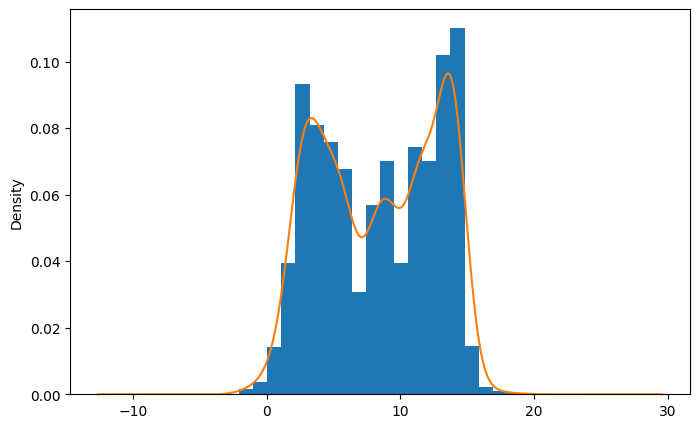

In [18]:
# look at the distribution of temperature

fig, ax = plt.subplots(figsize=(8,5))
temp_df.plot(kind='hist', ax=ax, density=True, bins=20)
temp_df.plot(kind='kde', ax=ax, label='Density')
plt.show()

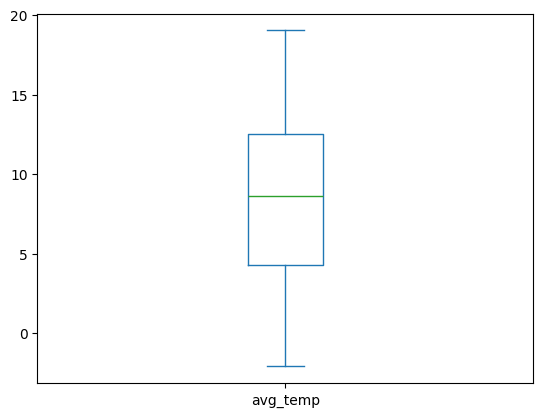

In [19]:
# box plot for temperature

temp_df.plot(kind='box')
plt.show()

In [20]:
pprint(temp_df.head().to_dict())

{Timestamp('1753-01-01 00:00:00'): 2.039,
 Timestamp('1753-02-01 00:00:00'): 0.7149999999999999,
 Timestamp('1753-03-01 00:00:00'): 5.424,
 Timestamp('1753-04-01 00:00:00'): 8.272,
 Timestamp('1753-05-01 00:00:00'): 12.186}


In [21]:
# sort the series

temp_df = temp_df.sort_index()

In [22]:
# final values of series

pprint(temp_df.tail(n=4).to_dict())

{Timestamp('2015-09-01 00:00:00'): 12.999,
 Timestamp('2015-10-01 00:00:00'): 10.800999999999998,
 Timestamp('2015-11-01 00:00:00'): 7.433,
 Timestamp('2015-12-01 00:00:00'): 5.518}


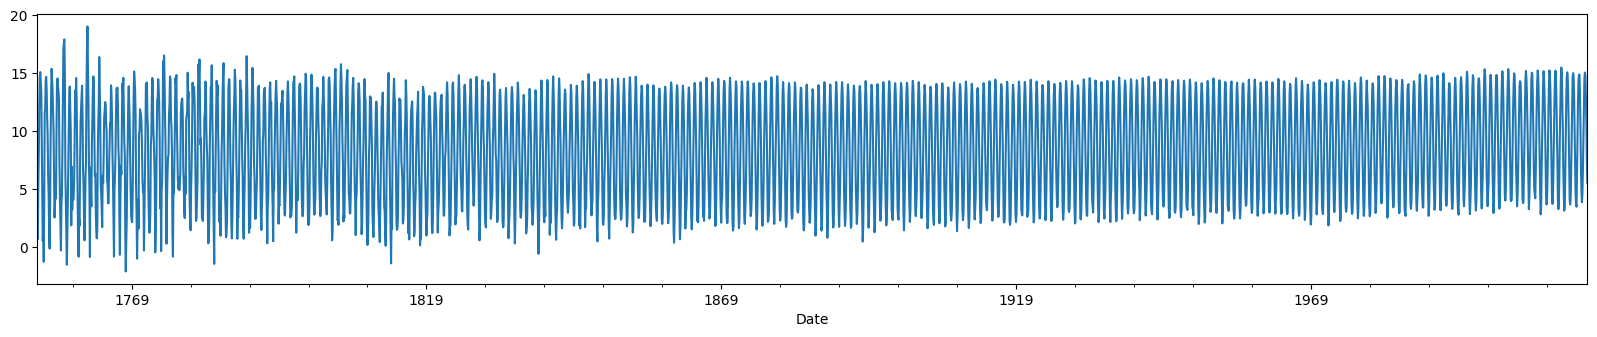

In [23]:
# average temperature plot

temp_df.plot(y='avg_temp', figsize=(20, 3.5))
plt.show()

<Axes: xlabel='Date'>

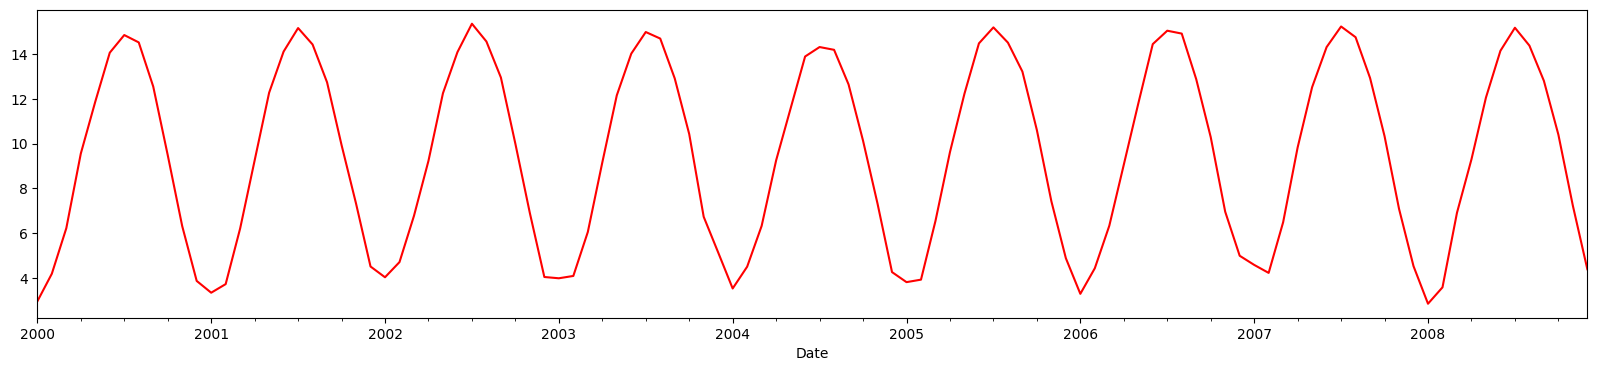

In [24]:
# average temperature subset plot

temp_df['2000-01-01':'2008-12-31'].plot(y = 'avg_temp', color='red', figsize=(20,4))

We can see from the plot above that there is a strong yearly seasonality. It is so strong that copying last year's value for this year will give us reasonable good solution. This **naive forecasting** will be one of our baseline.

We are shifting the data by 12 months.

In [25]:
n_periods = 12
y_true = temp_df[-2*n_periods:-n_periods]
y_naive = temp_df[-3*n_periods:2*-n_periods]
print("Naive y_true:", y_true.to_dict())
print("Naive y_pred:", y_naive.to_dict())

Naive y_true: {Timestamp('2014-01-01 00:00:00'): 3.732, Timestamp('2014-02-01 00:00:00'): 3.5, Timestamp('2014-03-01 00:00:00'): 6.377999999999999, Timestamp('2014-04-01 00:00:00'): 9.589, Timestamp('2014-05-01 00:00:00'): 12.582, Timestamp('2014-06-01 00:00:00'): 14.335, Timestamp('2014-07-01 00:00:00'): 14.873, Timestamp('2014-08-01 00:00:00'): 14.875, Timestamp('2014-09-01 00:00:00'): 13.091, Timestamp('2014-10-01 00:00:00'): 10.33, Timestamp('2014-11-01 00:00:00'): 6.712999999999999, Timestamp('2014-12-01 00:00:00'): 4.85}
Naive y_pred: {Timestamp('2013-01-01 00:00:00'): 3.685, Timestamp('2013-02-01 00:00:00'): 4.222, Timestamp('2013-03-01 00:00:00'): 6.261, Timestamp('2013-04-01 00:00:00'): 9.044, Timestamp('2013-05-01 00:00:00'): 12.195, Timestamp('2013-06-01 00:00:00'): 14.568, Timestamp('2013-07-01 00:00:00'): 15.003, Timestamp('2013-08-01 00:00:00'): 14.742, Timestamp('2013-09-01 00:00:00'): 13.154000000000002, Timestamp('2013-10-01 00:00:00'): 10.255999999999998, Timestamp('2

In [26]:
mae_naive_12_step = mean_absolute_error(y_true, y_naive)
print("MAE Naive Forecast (12-step):", mae_naive_12_step)

MAE Naive Forecast (12-step): 0.27400000000000013


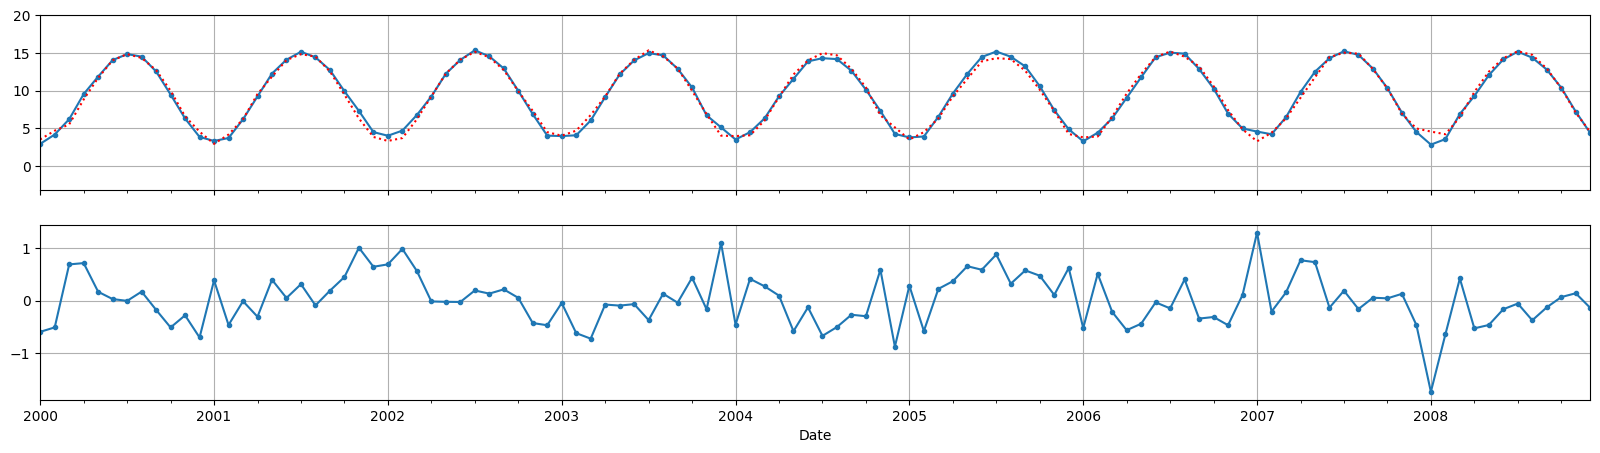

In [27]:
diff_year = temp_df.diff(12) # 12 month differenced series

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 5))

temp_df['2000-01-01':'2008-12-31'].plot(ax=axs[0], legend=False, marker='.') # original time series
temp_df.shift(12).plot(ax=axs[0], grid=True, legend=False, linestyle=':', color = 'red') # lagged series

diff_year['2000-01-01':'2008-12-31'].plot(ax=axs[1], grid=True, marker='.')
plt.show()

We can see from the plot above that lagged version of time series closely follows the original time series. We have autocorrelation here.

From the differenced series, we can see that we have removed seasonality from the dataset. Except for few like in 2008 there is a strong dip. Maybe something caused this.

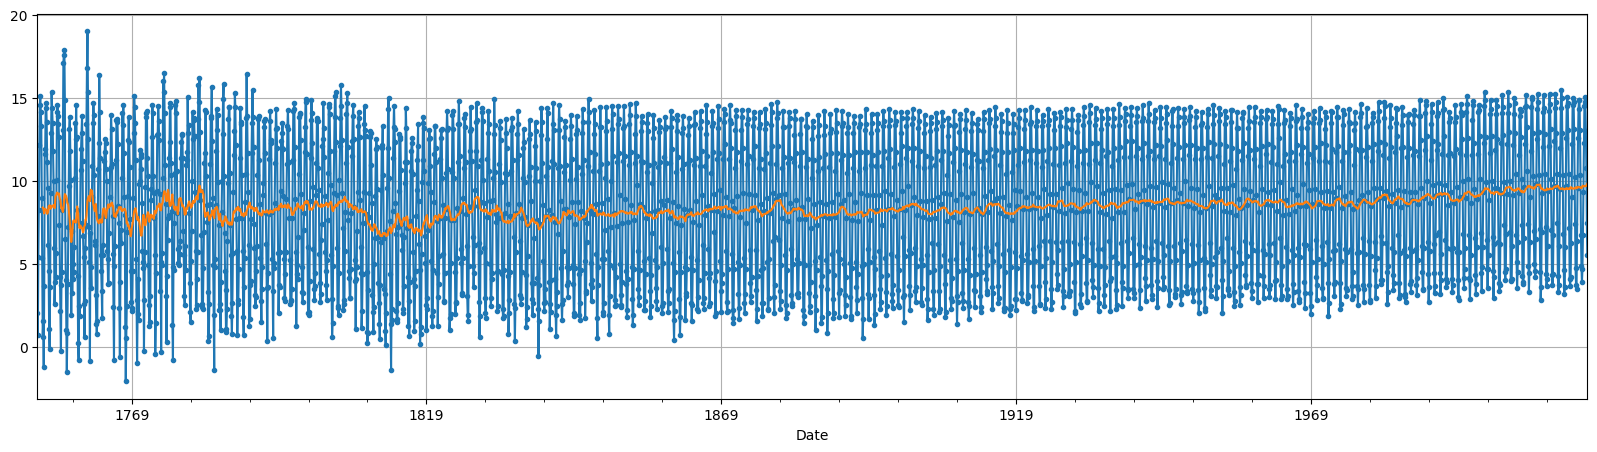

In [28]:
# rolling 12 month average to see the trend of Series

period = slice('1753', '2015')
rolling_average_12_months = temp_df[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(20,5))
temp_df[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

## Classical Statistical Model

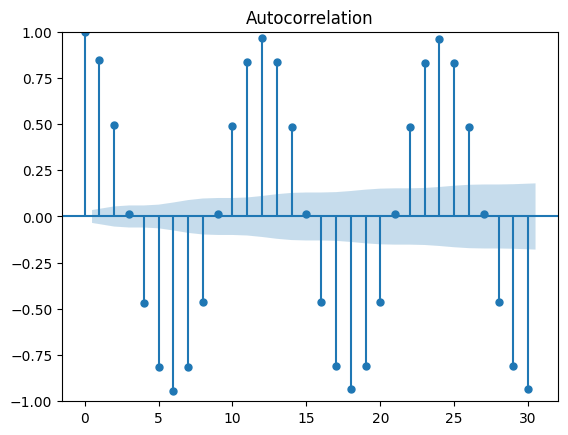

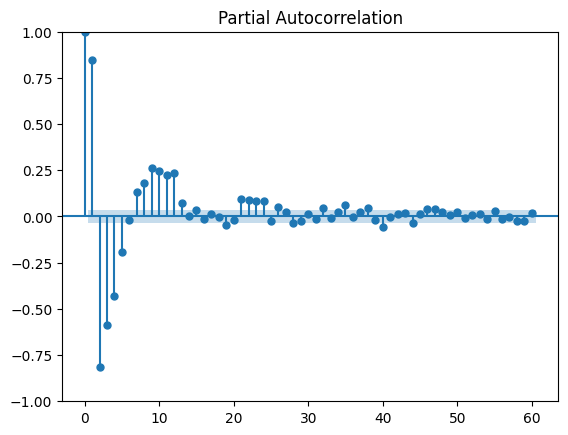

In [29]:
plot_acf(temp_df, lags=30)
# plt.savefig('acf_original_series.jpeg')
plot_pacf(temp_df, lags=60)
# plt.savefig('pacf_original_series.jpeg')
plt.show()

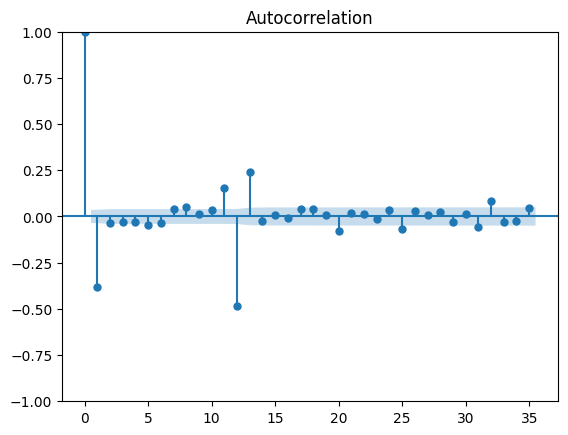

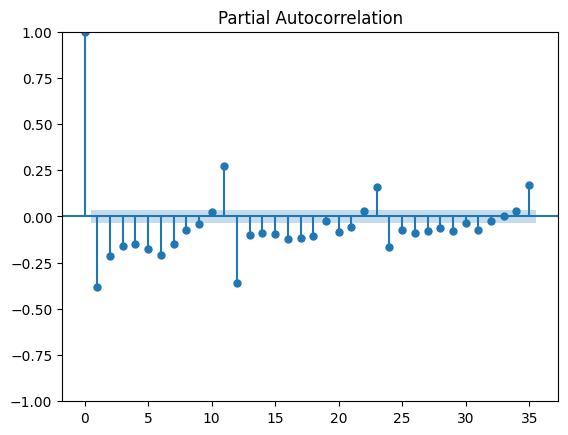

In [30]:
# differenced series pacf and acf

plot_acf(temp_df.diff(1).dropna().diff(12).dropna()) # after removing trend and seasonality
# plt.savefig('acf_diff_series.jpeg')
plot_pacf(temp_df.diff(1).dropna().diff(12).dropna())
# plt.savefig('pacf_diff_series.jpeg')
plt.show()

The initial inspection of the ACF and PACF plots for the original time series immediately identified two clear issues: non-stationarity and strong seasonality at lag 12. The slow, gradual decay in the ACF confirmed the presence of a trend, requiring a first-order non-seasonal differencing ($\mathbf{d=1}$). The large, significant spikes at every 12th lag in both the ACF and PACF plots confirmed a strong yearly cycle, necessitating a first-order seasonal differencing ($\mathbf{D=1}$) at a seasonal period of $s=12$.

After applying both non-seasonal and seasonal differencing, the series was rendered stationary.  The plots for this fully differenced series were then used to determine the specific AR/MA orders:

Seasonal Orders ($P, Q$): The large, isolated, and significant spikes remaining at Lag 12 in both the ACF and PACF plots strongly suggested the need for both a seasonal autoregressive term ($\mathbf{P=1}$) and a seasonal moving average term ($\mathbf{Q=1}$).

Non-Seasonal Orders ($p, q$): The PACF plot showed significant spikes at Lags 1 and Lag 12, suggesting $p=1$, while the ACF plot showed significant spikes at Lags 1, suggesting $q=1$. To maintain parsimony (model simplicity), we chose the simplest non-seasonal order $\mathbf{(1, 1, 1)}$

The final, fully diagnosed SARIMA model order is:$$\text{SARIMA}(1, 1, 1) \times (1, 1, 1)_{12}$$

In [31]:
# Lets remove trend and seasonality, to make our dataset stationary

# remove trend
temp_df_diff_1 = temp_df.diff(1).dropna()
# remove seasonality
temp_df_diff_2 = temp_df_diff_1.diff(12).dropna()

<Axes: xlabel='Date'>

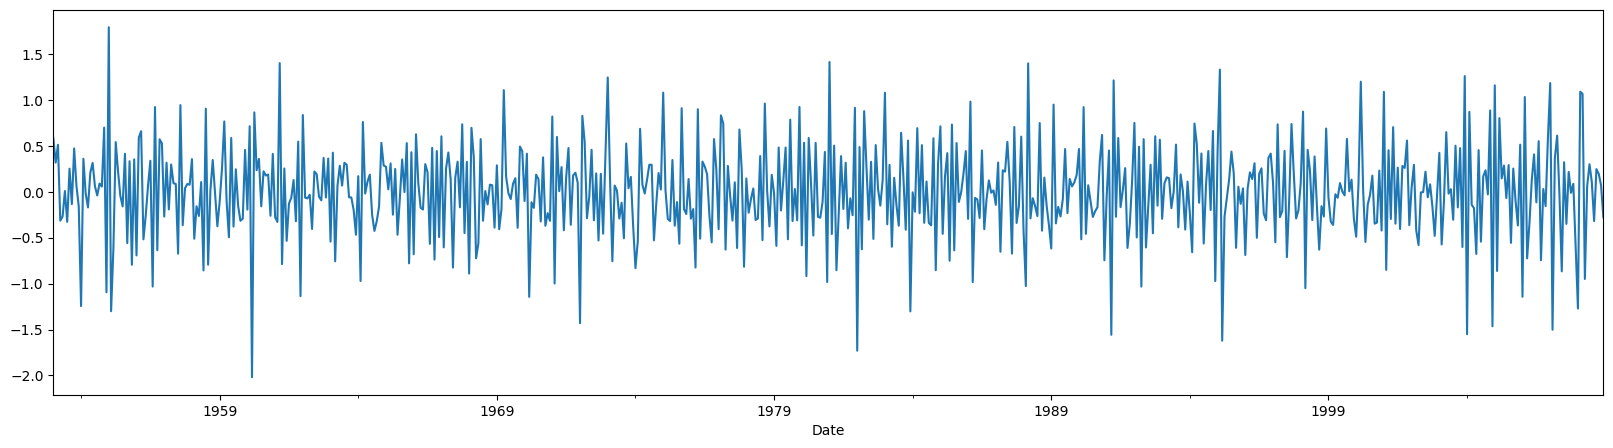

In [32]:
# verify time series is stationary

temp_df_diff_2['1953-01-01':'2008-12-31'].plot(figsize=(20,5))

### ARIMA and Auto ARIMA Model

Fitting ARIMA model

In [33]:
# ARIMA has (p, d, q):

# p → AR (autoregressive) order (how many past months to use)

# d → differencing order (to remove trend)

# q → MA (moving average) order (how many past errors to use)

# Seasonal part (P, D, Q, s):

# P → seasonal AR (how many past years to use)

# D → seasonal differencing → we differenced 12 → D=1

# Q → seasonal MA

# s → seasonal period → 12 months

In [34]:
# model training
data_to_fit_arima = temp_df['1753-01':'2013-12']
model = ARIMA(data_to_fit_arima.asfreq('MS'), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

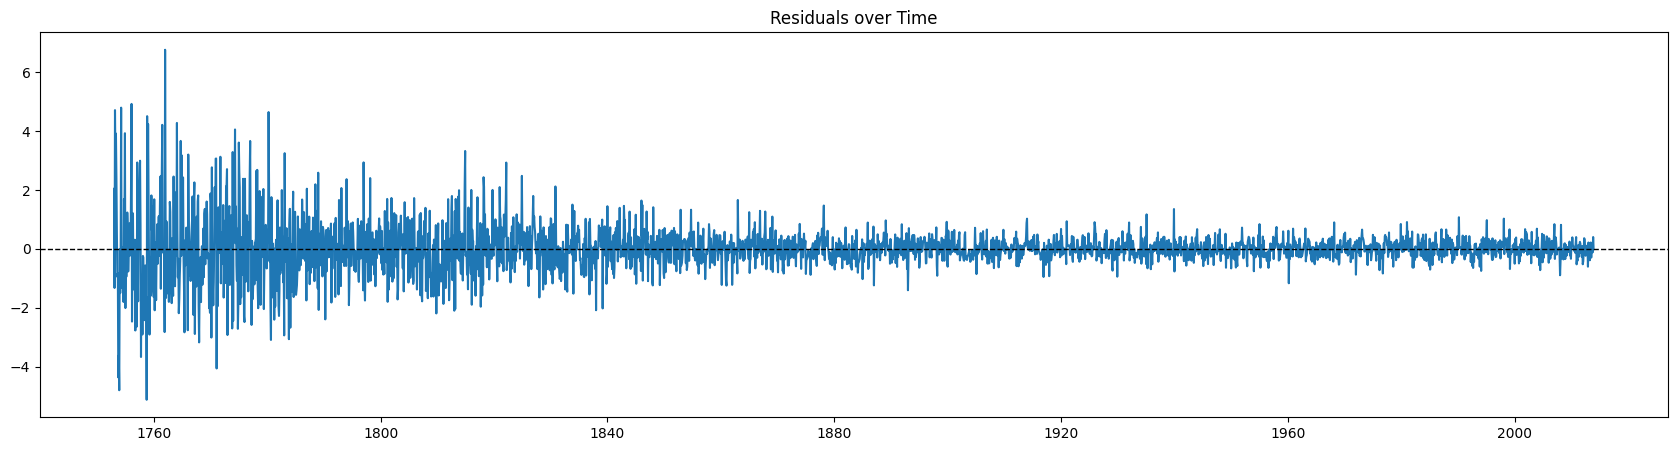

In [35]:
residual = results.resid

fig, axes = plt.subplots(figsize=(21,5))
plt.plot(residual)
plt.title("Residuals over Time")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.savefig('resid_arima_manual')
plt.show()


We can see that there is strong valatility at the beginning and it decays slowly and stabilizes. We see that residuals are heteroscedastic.

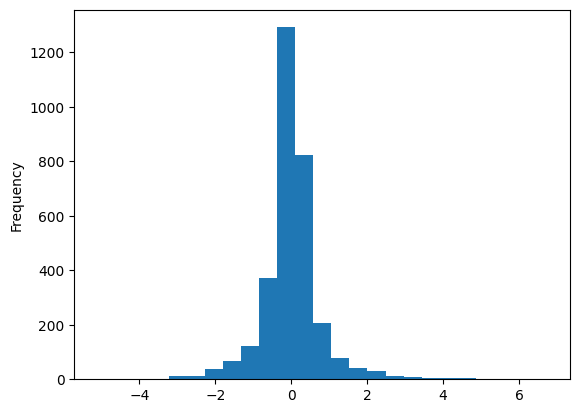

In [36]:
residual.plot(kind='hist',  bins=25)
plt.show()

In [37]:
lb = acorr_ljungbox(residual, lags = [12, 24], return_df=True)
print(lb)

      lb_stat     lb_pvalue
12  53.306001  3.633799e-07
24  83.694241  1.552502e-08


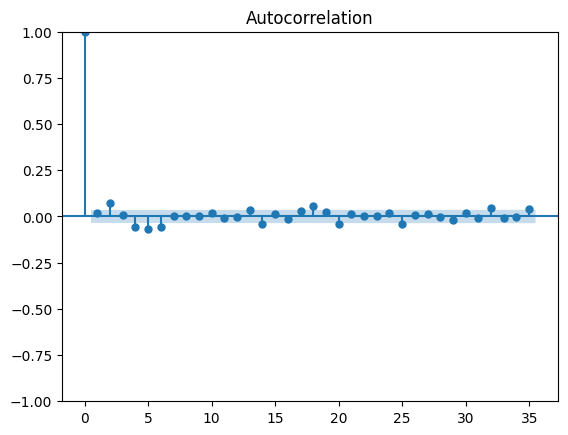

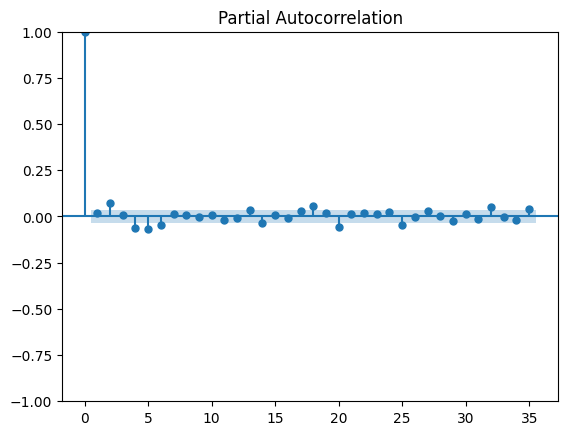

In [38]:
plot_acf(residual)
# plt.savefig('resid_arima_manual_acf')
plot_pacf(residual)
# plt.savefig('resid_arima_manual_pacf')
plt.show()

In [39]:
het_arch(residual)

(np.float64(605.7297318378799),
 np.float64(1.0423150875631577e-123),
 74.88961816188474,
 6.818287025129798e-138)

In [40]:
# ARIMA + GARCH
# This fixes heteroscedasticity without changing the ARIMA mean:
# This will model the declining volatility over time we observed in residual plot.
# Our acf and pacf tells us that order selection models the mean but residual plot tells us heteroscedastic variance

am = arch_model(results.resid, vol='Garch', p=1, q=1) # to model variance
garch_fit = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 357530.4065675362
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5934.633045185129
Iteration:      3,   Func. Count:     21,   Neg. LLF: 8210.182978582538
Iteration:      4,   Func. Count:     29,   Neg. LLF: 278889.93411209126
Iteration:      5,   Func. Count:     38,   Neg. LLF: 5935.080319756553
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7345.645995602104
Iteration:      7,   Func. Count:     52,   Neg. LLF: 922909368.1501297
Iteration:      8,   Func. Count:     61,   Neg. LLF: 70070918.0984491
Iteration:      9,   Func. Count:     69,   Neg. LLF: 14939269.199950483
Iteration:     10,   Func. Count:     75,   Neg. LLF: 109413.1389034967
Iteration:     11,   Func. Count:     84,   Neg. LLF: 5934.479862703931
Iteration:     12,   Func. Count:     90,   Neg. LLF: 43294434108996.37
Iteration:     13,   Func. Count:    105,   Neg. LLF: 7.942010110572357e+16
Iteration:     14,   Func. Count:    120,   Neg. LLF: 19110

In [41]:
# 12 step ahead forecast

n_periods = 12

arima_forecast = results.get_forecast(steps=n_periods)
mean_pred = arima_forecast.predicted_mean

garch_forecast = garch_fit.forecast(horizon=n_periods)
variance_pred = garch_forecast.variance.values[-1]

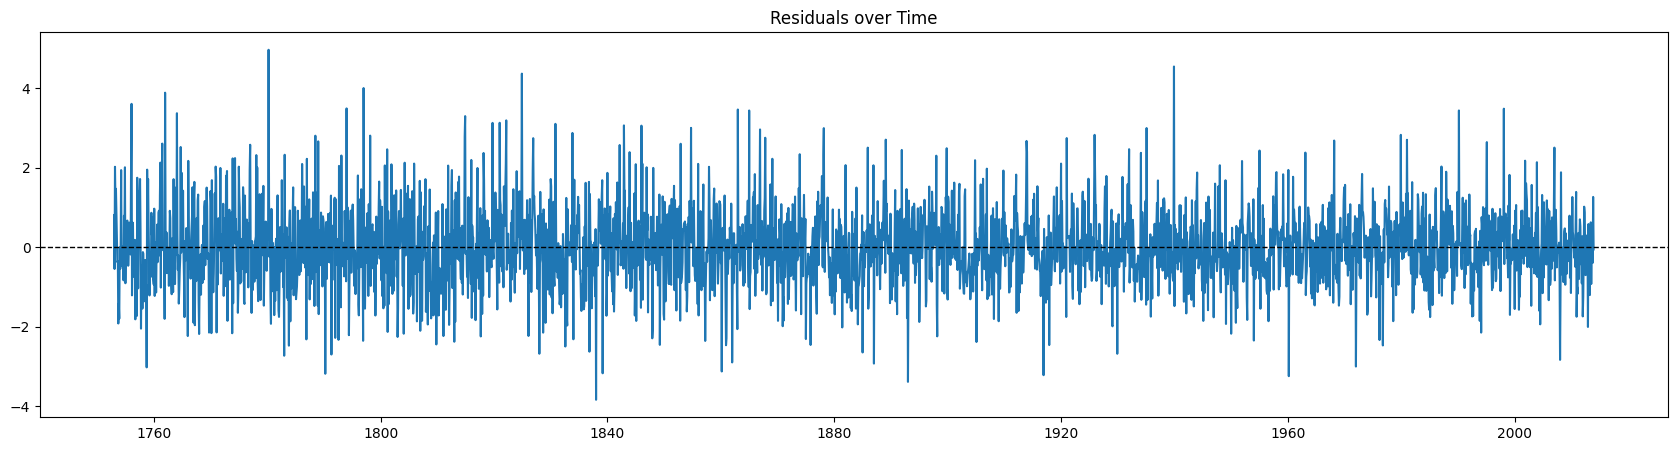

In [42]:
fig, axes = plt.subplots(figsize=(21,5))
plt.plot(garch_fit.std_resid)
plt.title("Residuals over Time")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.savefig('resid_garch')
plt.show()

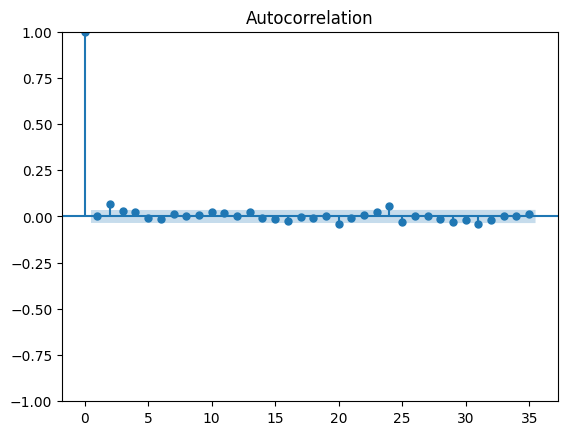

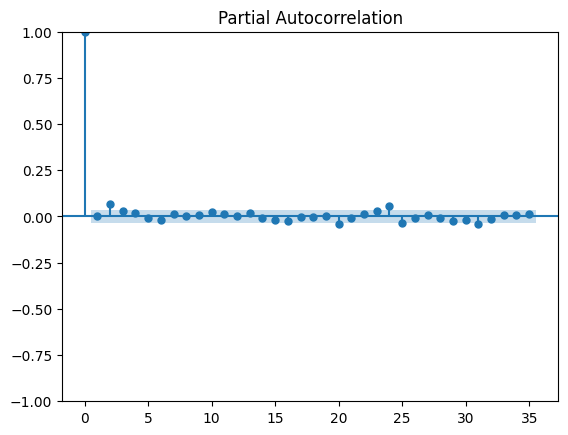

In [43]:
plot_acf(garch_fit.std_resid)
plot_pacf(garch_fit.std_resid)
plt.show()

In [44]:
final_forecast = mean_pred   # GARCH doesn't change the mean
forecast_std = np.sqrt(variance_pred) # Volatility Forecast

In [45]:
final_forecast

,predicted_mean
2014-01-01,3.723031
2014-02-01,4.250442
2014-03-01,6.337088
2014-04-01,9.415745
2014-05-01,12.248873
2014-06-01,14.410470
2014-07-01,15.253666
2014-08-01,14.786012
2014-09-01,13.005073
2014-10-01,10.331529


In [46]:
# trying auto arima and see what stepwise search finds us in the search space

auto_model = auto_arima(data_to_fit_arima.asfreq('MS'),
                        seasonal=True,
                        m=12,
                        start_p=0,
                        start_q=0,
                        max_p=2,
                        max_q=3,
                        start_P=0,
                        start_Q=0,
                        max_P=2,
                        max_Q=2,
                        d=1,
                        D=1,
                        trace=True,
                        stepwise=True
                        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=10237.904, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8939.612, Time=1.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=9746.669, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8689.398, Time=2.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.43 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.67 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=9155.938, Time=1.65 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8534.689, Time=3.89 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=8790.667, Time=1.64 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.70 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.05 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=21.55 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=21.20 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=8536.68

In [47]:
print(auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3132
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -4262.344
Date:                            Fri, 28 Nov 2025   AIC                           8534.689
Time:                                    23:33:59   BIC                           8564.915
Sample:                                01-01-1753   HQIC                          8545.539
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.010    -46.741      0.000      -0.476      -0.438
ar.L2         -0.2215      0.009   

In [48]:
auto_resid = auto_model.resid()

lb = acorr_ljungbox(auto_resid, lags = [12, 24], return_df=True)
print(lb)

       lb_stat     lb_pvalue
12  237.933801  4.464413e-44
24  357.784275  3.257417e-61


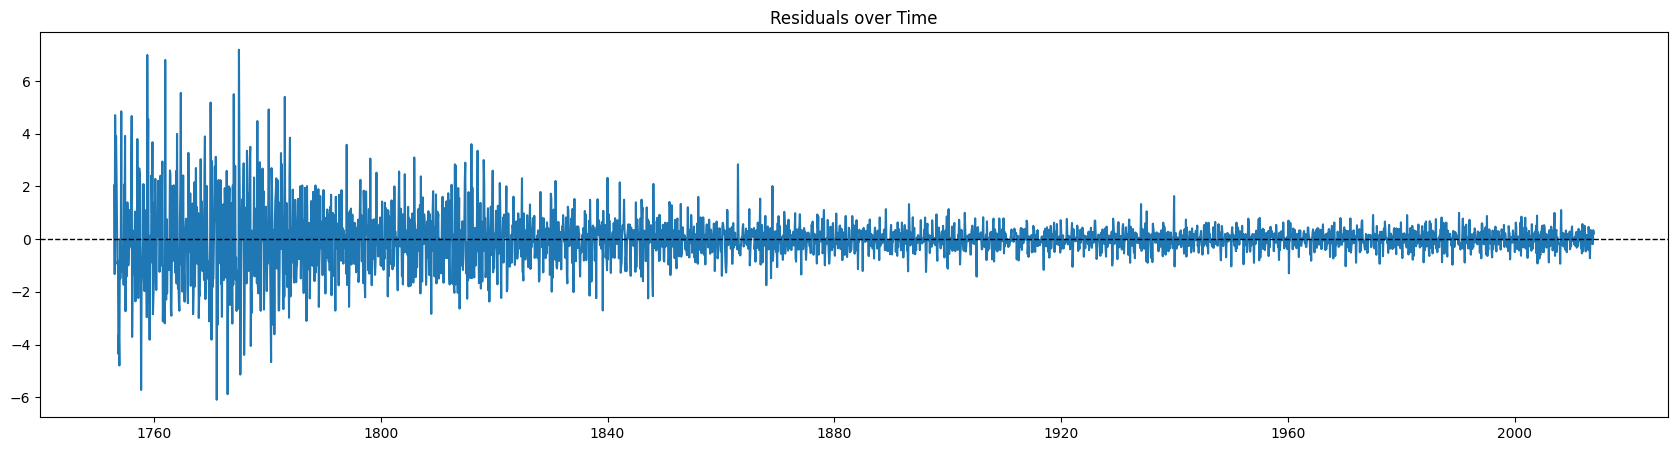

In [49]:
fig, axes = plt.subplots(figsize=(21,5))
plt.plot(auto_resid)
plt.title("Residuals over Time")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [50]:
# 12 step ahead forecast with auto arima

n_periods = 12
y_pred_auto, conf_interval = auto_model.predict(n_periods=n_periods, return_conf_int=True)
print(y_pred_auto)


2014-01-01     3.637215
2014-02-01     4.173762
2014-03-01     6.433586
2014-04-01     9.662110
2014-05-01    12.554215
2014-06-01    14.774596
2014-07-01    15.450044
2014-08-01    15.098401
2014-09-01    13.334438
2014-10-01    10.627676
2014-11-01     7.448421
2014-12-01     4.784039
Freq: MS, dtype: float64


In [51]:
y_true = temp_df['2014-01':'2014-12']
pprint(y_true.to_dict())

{Timestamp('2014-01-01 00:00:00'): 3.732,
 Timestamp('2014-02-01 00:00:00'): 3.5,
 Timestamp('2014-03-01 00:00:00'): 6.377999999999999,
 Timestamp('2014-04-01 00:00:00'): 9.589,
 Timestamp('2014-05-01 00:00:00'): 12.582,
 Timestamp('2014-06-01 00:00:00'): 14.335,
 Timestamp('2014-07-01 00:00:00'): 14.873,
 Timestamp('2014-08-01 00:00:00'): 14.875,
 Timestamp('2014-09-01 00:00:00'): 13.091,
 Timestamp('2014-10-01 00:00:00'): 10.33,
 Timestamp('2014-11-01 00:00:00'): 6.712999999999999,
 Timestamp('2014-12-01 00:00:00'): 4.85}


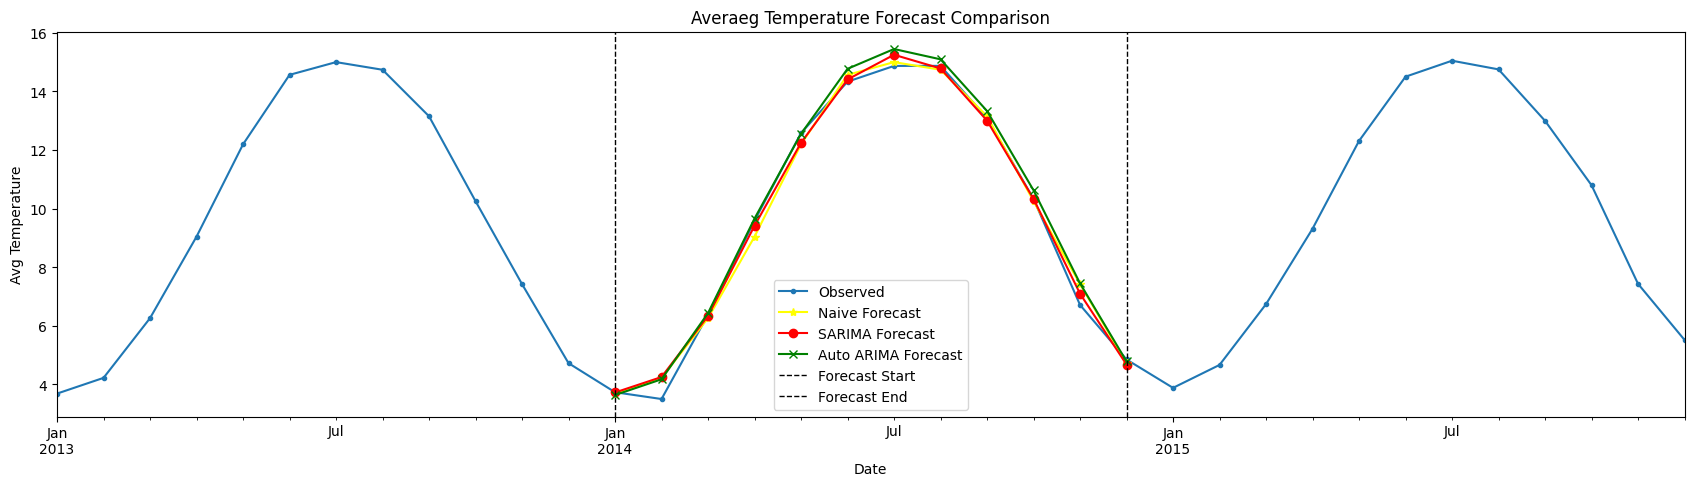

In [52]:
start_date, end_date = '2013-01-01', '2015-12-31'
time_period = pd.date_range(start_date, end_date, freq='MS')

fig, ax = plt.subplots(figsize=(21, 5))
temp_df.loc[time_period].plot(ax=ax, marker='.', label='Observed', grid=True)
y_naive_shifted = y_naive.copy()
y_naive_shifted.index = y_naive_shifted.index + pd.DateOffset(years=1)
y_naive_shifted.plot(ax=ax, marker='*', color='yellow', label='Naive Forecast')
final_forecast.plot(ax=ax, marker='o', color='r', label='SARIMA Forecast')
y_pred_auto.plot(ax=ax, marker='x', color='g', label='Auto ARIMA Forecast')
ax.axvline(pd.Timestamp('2014-01-01'), linestyle='--', color='k', linewidth=1, label='Forecast Start')
ax.axvline(pd.Timestamp('2014-12-31'), linestyle='--', color='k', linewidth=1, label='Forecast End')
plt.title("Averaeg Temperature Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Avg Temperature")
plt.legend()
plt.show()

In [53]:
mae_manual = mean_absolute_error(y_true, final_forecast)
mae_auto = mean_absolute_error(y_true, y_pred_auto)

print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("MAE Naive Forecast:", mae_naive_12_step)

MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
MAE Naive Forecast: 0.27400000000000013


## Neural Network Models

In [54]:
# train, test and valid split

In [55]:
temp_df.head()

,avg_temp
Date,
1753-01-01,2.039
1753-02-01,0.715
1753-03-01,5.424
1753-04-01,8.272
1753-05-01,12.186


In [56]:
# We need to split before differencing since first row of each split depends on a value from the previous split.

temp_train_raw = temp_df['1753-01':'1997-12']
temp_valid_raw = temp_df['1998-01':'2014-12']
temp_test_raw = temp_df['2015-01':]

In [57]:
# function to temporiraly include 12 months of data from before the split only to compute the differences then drop it after diffencing to handle zero leakage4

def difference_with_history(raw_split, full_series, lags=(1,12)):
  # How many past points needed?
  required_history = max(lags) + 1 # for (1, 12): 12 months
  split_start = pd.to_datetime(raw_split.index[0])
  history_start = split_start - pd.DateOffset(months=required_history)
  extended = full_series.loc[history_start:raw_split.index[-1]] # pull needed history from the full raw series
  # applying differencing in order
  diffed = extended.copy()
  for lag in lags:
    diffed = diffed.diff(lag)
  diffed = diffed.dropna() # drop NaNs from differencing
  diffed = diffed.loc[diffed.index >= split_start] # keep only rows that belong in the split

  return diffed

In [58]:
# differenced series
temp_train_diff = difference_with_history(temp_train_raw, temp_df)
temp_valid_diff = difference_with_history(temp_valid_raw, temp_df)
temp_test_diff = difference_with_history(temp_test_raw, temp_df)

In [59]:
# min max scaled series

scaler = MinMaxScaler()
temp_train_scaled = scaler.fit_transform(temp_train_diff.values.reshape(-1,1))
temp_valid_scaled = scaler.transform(temp_valid_diff.values.reshape(-1,1))
temp_test_scaled = scaler.transform(temp_test_diff.values.reshape(-1,1))

In [60]:
temp_train = pd.DataFrame(temp_train_scaled, index=temp_train_diff.index, columns=['diff_temp_scaled'])
temp_valid = pd.DataFrame(temp_valid_scaled, index=temp_valid_diff.index, columns=['diff_temp_scaled'])
temp_test = pd.DataFrame(temp_test_scaled, index=temp_test_diff.index, columns=['diff_temp_scaled'])

In [61]:
# check the train differencing

temp_train.head().to_dict()

{'diff_temp_scaled': {Timestamp('1754-02-01 00:00:00'): 0.4163658243080627,
  Timestamp('1754-03-01 00:00:00'): 0.506147648197562,
  Timestamp('1754-04-01 00:00:00'): 0.7608434050122954,
  Timestamp('1754-05-01 00:00:00'): 0.3070684874169415,
  Timestamp('1754-06-01 00:00:00'): 0.4975671009260713}}

In [62]:
# check the valid differencing

temp_valid.head().to_dict()

{'diff_temp_scaled': {Timestamp('1998-01-01 00:00:00'): 0.49976455815413606,
  Timestamp('1998-02-01 00:00:00'): 0.5404698372835244,
  Timestamp('1998-03-01 00:00:00'): 0.43991000889446974,
  Timestamp('1998-04-01 00:00:00'): 0.5186522262334539,
  Timestamp('1998-05-01 00:00:00'): 0.5068801339402502}}

In [63]:
# check the test differencing

temp_test.head().to_dict()

{'diff_temp_scaled': {Timestamp('2015-01-01 00:00:00'): 0.49599748862031084,
  Timestamp('2015-02-01 00:00:00'): 0.5478993355307906,
  Timestamp('2015-03-01 00:00:00'): 0.4528331502118978,
  Timestamp('2015-04-01 00:00:00'): 0.4614136974833883,
  Timestamp('2015-05-01 00:00:00'): 0.4951080416470465}}

In [64]:
temp_train.shape, temp_valid.shape, temp_test.shape

((2927, 1), (204, 1), (12, 1))

In [65]:
# From 2015 to 2025 data is missing here (....)

In [66]:
# preparing dataset for Sequence to Vector One Step Forecast Models

# creating training dataset

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data = temp_train[:-12].to_numpy(),
    targets=temp_train[12:],# shift the target forward by 12 months; the model predicts the temperature 12 months after the end of each 12-month input window
    sequence_length = 12, # each input sample will be a consecutive 12 months differenced temperature
    batch_size = 10, # create batches of size 10 that is each batch gets 10 inputs sequence with each input sequence having 12 months of temperature values
    # shuffle=True,
    shuffle=False,
    seed=42
)

In [67]:
pprint(temp_train.head(n=10).to_dict()) # to see shuffle effect

{'diff_temp_scaled': {Timestamp('1754-02-01 00:00:00'): 0.4163658243080627,
                      Timestamp('1754-03-01 00:00:00'): 0.506147648197562,
                      Timestamp('1754-04-01 00:00:00'): 0.7608434050122954,
                      Timestamp('1754-05-01 00:00:00'): 0.3070684874169415,
                      Timestamp('1754-06-01 00:00:00'): 0.4975671009260713,
                      Timestamp('1754-07-01 00:00:00'): 0.4835975514048031,
                      Timestamp('1754-08-01 00:00:00'): 0.4853241249411397,
                      Timestamp('1754-09-01 00:00:00'): 0.4110291424684771,
                      Timestamp('1754-10-01 00:00:00'): 0.6419714330560353,
                      Timestamp('1754-11-01 00:00:00'): 0.5046303563019935}}


In [68]:
# visualizing first two batches of data

for i, (x, y) in enumerate(train_ds):
  print(f"Batch {i}")
  print("X (inputs):\n", x.numpy())
  print("Y (targets):\n", y.numpy())
  print("-"*30)
  if i == 1:  # stop after 2 batches
    break

Batch 0
X (inputs):
 [[[0.41636582]
  [0.50614765]
  [0.76084341]
  [0.30706849]
  [0.4975671 ]
  [0.48359755]
  [0.48532412]
  [0.41102914]
  [0.64197143]
  [0.50463036]
  [0.66326584]
  [0.25752106]]

 [[0.50614765]
  [0.76084341]
  [0.30706849]
  [0.4975671 ]
  [0.48359755]
  [0.48532412]
  [0.41102914]
  [0.64197143]
  [0.50463036]
  [0.66326584]
  [0.25752106]
  [0.58101816]]

 [[0.76084341]
  [0.30706849]
  [0.4975671 ]
  [0.48359755]
  [0.48532412]
  [0.41102914]
  [0.64197143]
  [0.50463036]
  [0.66326584]
  [0.25752106]
  [0.58101816]
  [0.4314341 ]]

 [[0.30706849]
  [0.4975671 ]
  [0.48359755]
  [0.48532412]
  [0.41102914]
  [0.64197143]
  [0.50463036]
  [0.66326584]
  [0.25752106]
  [0.58101816]
  [0.4314341 ]
  [0.37566055]]

 [[0.4975671 ]
  [0.48359755]
  [0.48532412]
  [0.41102914]
  [0.64197143]
  [0.50463036]
  [0.66326584]
  [0.25752106]
  [0.58101816]
  [0.4314341 ]
  [0.37566055]
  [0.66703291]]

 [[0.48359755]
  [0.48532412]
  [0.41102914]
  [0.64197143]
  [0.5046

In [69]:
# creating validation dataset

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    temp_valid[:-12].to_numpy(),
    targets=temp_valid[12:],
    sequence_length = 12,
    batch_size = 5,
    shuffle=False,
    seed=42
)

In [70]:
for i, (x, y) in enumerate(valid_ds):
  print(f"Batch {i}")
  print("X (inputs):\n", x.numpy())
  print("Y (targets):\n", y.numpy())
  print("-"*30)
  if i == 1:  # stop after 2 batches
    break


Batch 0
X (inputs):
 [[[0.49976456]
  [0.54046984]
  [0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]]

 [[0.54046984]
  [0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]]

 [[0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]]

 [[0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]
  [0.47590645]]

 [[0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]
  [0.47590645]
  [0.49338147]]]
Y (targets):
 [[0.49165489]
 [0.47784231]
 [0.47590645]
 [0.49338147]

In [71]:
# One-step-Forecasts (Sequence to Vector Models)

### Linear Model - Sequence to Vector - One Step Forecast

In [72]:
# creating a linear model

linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[12]), #shape: the model expects 1D vector of length 12 i.e, sequence length fixed at 12
    tf.keras.layers.Dense(1)
])

# simple sequence-to-vector model for a fixed-length input

In [73]:
print(linear_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [74]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = "val_mae",
    patience = 20,
    min_delta = 0.0001,
    restore_best_weights = True
)

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

linear_model.compile(loss = tf.keras.losses.Huber(),
                     optimizer=opt,
                     metrics=['mae']
                     )

linear_history = linear_model.fit(train_ds,
                                  validation_data=valid_ds,
                                  epochs=500,
                                  callbacks=[early_stopping_cb]
                                  )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0270 - mae: 0.1618 - val_loss: 0.0014 - val_mae: 0.0432
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - mae: 0.1394 - val_loss: 0.0013 - val_mae: 0.0423
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - mae: 0.1358 - val_loss: 0.0013 - val_mae: 0.0411
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - mae: 0.1314 - val_loss: 0.0012 - val_mae: 0.0398
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - mae: 0.1264 - val_loss: 0.0011 - val_mae: 0.0383
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - mae: 0.1212 - val_loss: 9.9433e-04 - val_mae: 0.0367
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - mae: 0.1158 - val_loss: 9.0961e-04 - val_mae: 0.0351
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - mae: 0.1104 - val_loss: 8.2964e-04 - val_mae: 0.0335
Epoch 9/500
291/291 ━━━━━━━━━━━━━━━━

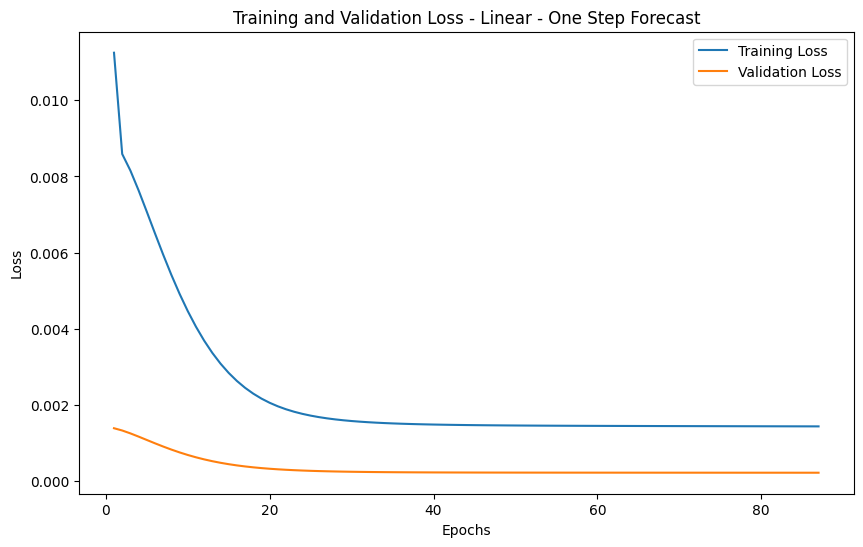

In [75]:
# linear model loss plot

linear_train_loss = linear_history.history['loss']
linear_val_loss = linear_history.history['val_loss']
epochs = range(1, len(linear_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, linear_train_loss, label='Training Loss')
plt.plot(epochs, linear_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Linear - One Step Forecast')
plt.legend()
plt.show()
# plt.savefig('linear.jpeg')

The loss plot for the linear model clearly shows that the validation loss (orange line) is consistently lower and parallel to the training loss (blue line). This is a great sign! It means our simple model is generalizing perfectly and has successfully captured the main, easy-to-find patterns in differenced and scaled temperature data without trying to memorize any specific noise from the training examples (which is called overfitting).

In [76]:
min(linear_history.history['val_mae'])
# this is in different scale than naive forecast and ARIMA AUTO ARIMA. Hence we need to inverse transform

0.016118982806801796

In [77]:
y_pred_scaled = linear_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_linear = mean_absolute_error(y_val, y_pred)
print("MAE Linear (One Step Forecast Error)", mae_linear)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE Linear (One Step Forecast Error) 0.3094486068913235


The above sliding window (sequence to vector, one step forecast) model has no recurrent or convolution processing, the model just learns a linear (or non linear if we add activations) mapping from a fixed-length input sequence to one output.

Input: $[t-11, t-10, ..., t]$ -> 12 numbers

Dense layer does not know that $t-11$ comes before $t-10$ and so on.

It just applies a linear combination of all the 12 numbers (each multiplied by the weight) plus a bias, and outputs 1 number.

Mathematically,

$$
y_{pred} = w_1x_1 + w_2x_2+...+w_{12}x_{12} + b
$$

where

$x_1 = t-11, x_2=t-10, ..., x_{12} = t$

The dense layer treats all inputs equally, it does not know the order matters.

Dense layer treats input as a simple 12-element vector, no temporal dynamics.It takes the entire 12-step input vector and maps it to a single scalar output, the predicted value for the next month.

In [78]:
# RECURSIVE PREDICTION (ROLL FORWARD) LOGIC ---

# 3a. Recursive Function
def perform_recursive_forecast(model, initial_window: np.ndarray, true_future_values: np.ndarray, steps: int = 12) -> tuple:
  """
  Implements the 'roll forward' strategy for multi-step forecasting.
  Returns both the scaled predictions and the MAE.
  """

  forecasted_sequence = []
  current_input = initial_window.copy()

  # The model expects input shape (batch_size, sequence_length) -> (1, 12)
  # We flatten the last dimension if it exists, as the linear model expects (1, 12)
  if current_input.ndim == 3 and current_input.shape[2] == 1:
    current_input = current_input.reshape(current_input.shape[0], current_input.shape[1])

  for _ in range(steps):
    # 1. Predict one step (output shape is (1, 1))
    prediction = model.predict(current_input, verbose=0)

    # 2. Store the prediction (extract the single value)
    forecasted_sequence.append(prediction[0, 0])

    # 3. Roll the window forward (Discard oldest, add prediction)
    # Shift all elements one step to the left
    current_input = np.roll(current_input, shift=-1, axis=1)

    # Replace the last element (which is a duplicate due to roll) with the new prediction
    current_input[0, -1] = prediction[0, 0]

  # 4. Final Evaluation (Scaled)
  y_pred_recursive_scaled = np.array(forecasted_sequence).reshape(-1, 1)

  # Ensure true_future_values is flattened before comparison
  mae_scaled = mean_absolute_error(true_future_values.flatten(), y_pred_recursive_scaled.flatten())

  return y_pred_recursive_scaled, mae_scaled

In [79]:
# Get the last input sequence from the validation data
# valid_ds is a Keras dataset; we need to extract the raw features used to create it.
X_valid_raw = temp_valid[:-12].to_numpy()

initial_window_scaled = temp_valid.iloc[-2 * 12 : -12].to_numpy().reshape(1, 12)

# Get the 12 true future values that follow the initial window
# The validation set spans '1998-01' to '2014-12'. The true 12 steps start 12 months after
# the end of X_valid_raw. The last point of X_valid_raw is at temp_valid[:-12]
# The true future values are the last 12 points of the temp_valid data.
true_future_scaled = temp_valid.iloc[-12:].values.reshape(-1, 1)


# Recursive Forecast
y_pred_recursive_scaled, mae_scaled_recursive = perform_recursive_forecast(
    model=linear_model,
    initial_window=initial_window_scaled,
    true_future_values=true_future_scaled,
    steps=12
)

# Inverse Transform and Final MAE

# Inverse transform the true future values and predictions to the original temperature scale.
y_true_recursive_original = scaler.inverse_transform(true_future_scaled)
y_pred_recursive_original = scaler.inverse_transform(y_pred_recursive_scaled)

# Calculate the final MAE on the original (unscaled) temperature data.
final_recursive_mae_linear = mean_absolute_error(
    y_true_recursive_original,
    y_pred_recursive_original
)

print(f"\n--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---")
print(f"Initial Window Start Date: {temp_valid.index[-(12 * 2)]}")
print(f"Forecast Horizon Start Date: {temp_valid.index[-12]}")


--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---
Initial Window Start Date: 2013-01-01 00:00:00
Forecast Horizon Start Date: 2014-01-01 00:00:00


In [80]:
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


### Simple Recurrent Neural Network - Sequence to Vector - One Step Forecast

In [81]:
# creating RNN model - sequence to vector - one step forecas

rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]), # variable sequence length, 1 feature (dimension 1 feature since we are predicting univariate time series)
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=False), # default activation
    tf.keras.layers.Dense(1, activation=None)
])

# Input: a sequence of shape [[t1], [t2], ..., [t12]] (one time series value per timestep from the sequence)
# RNN layer outputs only the **last hidden state** (h12), not all hidden states.
# Dense layer is applied to this last hidden state to produce a single output [o13].
# The model predicts **the next timestep** (e.g., next month) from the past sequence


In [82]:
print(rnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [83]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     min_delta=0.0001,
                                                     patience = 20,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

rnn_model.compile(loss = tf.keras.losses.Huber(),
                  optimizer=opt,
                  metrics=['mae']
                  )
rnn_history = rnn_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0068 - mae: 0.0791 - val_loss: 3.1043e-04 - val_mae: 0.0189
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0040 - mae: 0.0615 - val_loss: 2.4194e-04 - val_mae: 0.0167
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0035 - mae: 0.0575 - val_loss: 2.2244e-04 - val_mae: 0.0160
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0033 - mae: 0.0562 - val_loss: 2.1314e-04 - val_mae: 0.0157
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0032 - mae: 0.0556 - val_loss: 2.0864e-04 - val_mae: 0.0156
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0032 - mae: 0.0552 - val_loss: 2.0519e-04 - val_mae: 0.0156
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0032 - mae: 0.0549 - val_loss: 2.0285e-04 - val_mae: 0.0155
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0031 - mae: 0.0547 - val_loss: 2.0160e-04 - val_mae: 0.0155
Epoch 9/

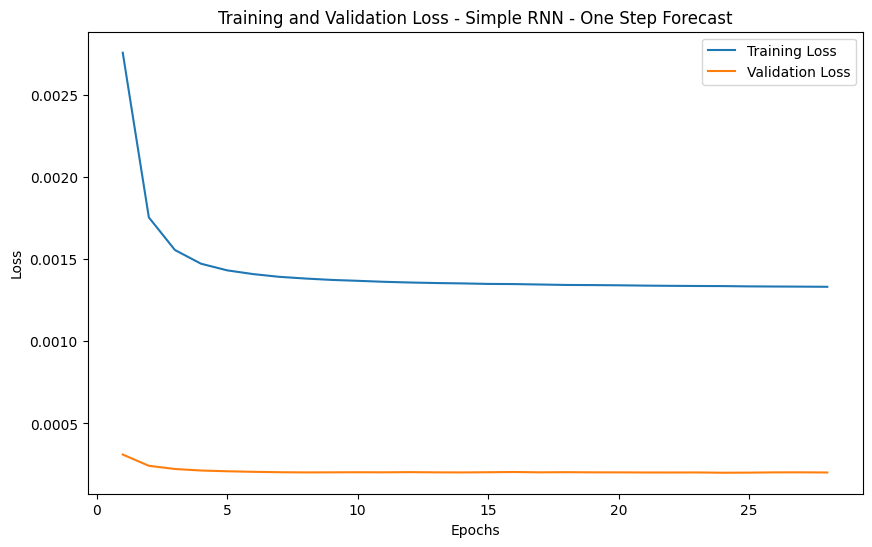

In [84]:
# RNN model loss plot

rnn_train_loss = rnn_history.history['loss']
rnn_val_loss = rnn_history.history['val_loss']
epochs = range(1, len(rnn_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, rnn_train_loss, label='Training Loss')
plt.plot(epochs, rnn_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Simple RNN - One Step Forecast')
plt.legend()
plt.show()
# plt.savefig("rnn_seq2vec_one_step.jpeg")

Why the SimpleRNN is Not a Good Choice for Time Series?

SimpleRNN architecture has limitations:

Vanishing Gradients: SimpleRNNs struggle to pass information across long input sequences (in our case, 12 months). The gradient signal used for learning often becomes too small ("vanishes") by the time it reaches the first time steps, making it difficult for the model to use older data to make accurate predictions. This is the primary cause of the high, stuck Training Loss (underfitting).

Instability: The simple structure lacks the specialized "gates" found in modern RNNs (like GRUs and LSTMs) that regulate the flow of information. Without these gates, the network is highly sensitive to input noise and weight changes, leading to the chaotic, spiky behavior seen in the Validation Loss.

In [85]:
y_pred_scaled = rnn_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_rnn = mean_absolute_error(y_val, y_pred)
print("One Step Validation Error (Simple RNN):", mae_rnn)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
One Step Validation Error (Simple RNN): 0.2954496520541464


In [86]:
X_valid_raw = temp_valid[:-12].to_numpy()

initial_window_scaled = temp_valid.iloc[-2 * 12 : -12].to_numpy().reshape(1, 12)
true_future_scaled = temp_valid.iloc[-12:].values.reshape(-1, 1)

y_pred_recursive_scaled, mae_scaled_recursive = perform_recursive_forecast(
    model=rnn_model,
    initial_window=initial_window_scaled,
    true_future_values=true_future_scaled,
    steps=12
)

y_true_recursive_original = scaler.inverse_transform(true_future_scaled)
y_pred_recursive_original = scaler.inverse_transform(y_pred_recursive_scaled)

final_recursive_mae_rnn = mean_absolute_error(
    y_true_recursive_original,
    y_pred_recursive_original
)

print(f"\n--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---")
print(f"Initial Window Start Date: {temp_valid.index[-(12 * 2)]}")
print(f"Forecast Horizon Start Date: {temp_valid.index[-12]}")


--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---
Initial Window Start Date: 2013-01-01 00:00:00
Forecast Horizon Start Date: 2014-01-01 00:00:00


In [87]:
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.35470637161533114
Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


### GRU Model - Sequence to Vector - One Step Forecast

LSTM and GRU architectures have gating mechanisms designed to overcome the vanishing gradient probelm, allowing the model to effectively learn patterns that span many time steps.

Let's train the GRU models now

In [88]:
# gru model - sequence to vector, one step forecast

gru_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.GRU(
        32,
        activation='tanh',
        return_sequences=False,
        # recurrent_dropout=0.05
    ),
    tf.keras.layers.Dense(1)
])

In [89]:
print(gru_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [90]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     min_delta=0.0001,
                                                     patience = 20,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

gru_model.compile(loss = tf.keras.losses.Huber(),
                  optimizer=opt,
                  metrics=['mae']
                  )

gru_history = gru_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0426 - mae: 0.1979 - val_loss: 3.8940e-04 - val_mae: 0.0208
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - mae: 0.0696 - val_loss: 3.7477e-04 - val_mae: 0.0205
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050 - mae: 0.0684 - val_loss: 3.6060e-04 - val_mae: 0.0201
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - mae: 0.0673 - val_loss: 3.4824e-04 - val_mae: 0.0198
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - mae: 0.0664 - val_loss: 3.3778e-04 - val_mae: 0.0196
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - mae: 0.0656 - val_loss: 3.2896e-04 - val_mae: 0.0194
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - mae: 0.0650 - val_loss: 3.2128e-04 - val_mae: 0.0192
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - mae: 0.0644 - val_loss: 3.1438e-04 - val_mae: 0.0190
Epoch 9/500
291/

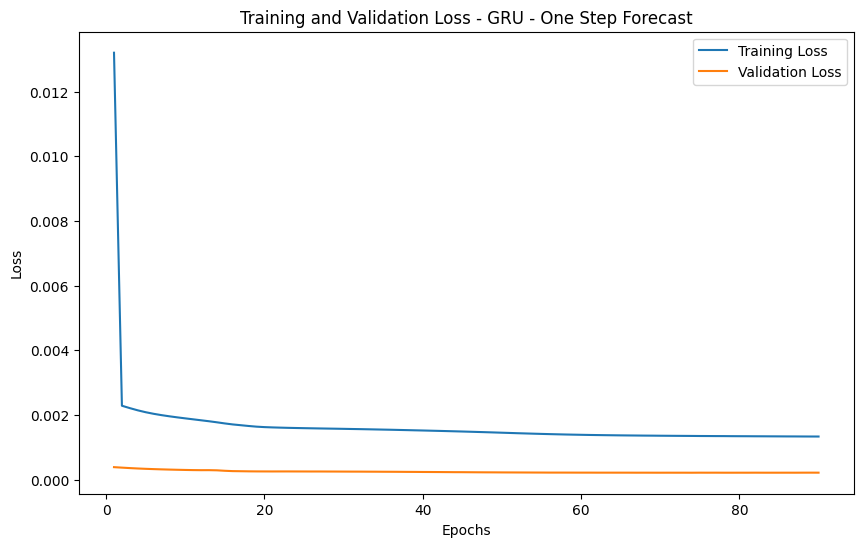

In [91]:
gru_train_loss = gru_history.history['loss']
gru_val_loss = gru_history.history['val_loss']
epochs = range(1, len(gru_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_train_loss, label='Training Loss')
plt.plot(epochs, gru_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - One Step Forecast')
plt.legend()
plt.show()
# plt.savefig('gru_seq2vec_one_step.jpeg')

In [92]:
y_pred_scaled = gru_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_gru = mean_absolute_error(y_val, y_pred)
print("One Step Validation Error GRU", mae_gru)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
One Step Validation Error GRU 0.3085933913782018


In [93]:
X_valid_raw = temp_valid[:-12].to_numpy()

initial_window_scaled = temp_valid.iloc[-2 * 12 : -12].to_numpy().reshape(1, 12)
true_future_scaled = temp_valid.iloc[-12:].values.reshape(-1, 1)

y_pred_recursive_scaled, mae_scaled_recursive = perform_recursive_forecast(
    model=gru_model,
    initial_window=initial_window_scaled,
    true_future_values=true_future_scaled,
    steps=12
)

y_true_recursive_original = scaler.inverse_transform(true_future_scaled)
y_pred_recursive_original = scaler.inverse_transform(y_pred_recursive_scaled)

final_recursive_mae_gru = mean_absolute_error(
    y_true_recursive_original,
    y_pred_recursive_original
)

print(f"\n--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---")
print(f"Initial Window Start Date: {temp_valid.index[-(12 * 2)]}")
print(f"Forecast Horizon Start Date: {temp_valid.index[-12]}")


--- 12-STEP RECURSIVE (ROLL FORWARD) MAE (Final Result) ---
Initial Window Start Date: 2013-01-01 00:00:00
Forecast Horizon Start Date: 2014-01-01 00:00:00


In [94]:
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.36522396803771534
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.35470637161533114
Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


#### Model Hierarchy and Analysis - Single Step

The final hierarchy of the models confirms the principle of Model Parsimony for highly pre-processed data:

**Manual ARIMA: The Overall Winner**  
The Manual ARIMA remains the overall winner, as it explicitly captures the linear and seasonal structure of the monthly temperature series. This result demonstrates that when the underlying time series components are well-understood and strongly autocorrelated, a carefully tuned statistical model can outperform data-driven deep learning models, setting a very strong benchmark for this problem.

**Naive and Linear Baselines: Strong Competitors**  
Both the naive forecast and the linear model perform reasonably well, reflecting the strong month-to-month persistence and predictable seasonality in the series. These simpler approaches already capture most of the signal, which explains why small neural networks struggle to provide additional improvements in single-step forecasting.

**SimpleRNN: The Best Deep Learning Alternative**  
Among the neural networks, the SimpleRNN slightly outperforms the GRU. Its simpler architecture is sufficient to capture the short-term dependencies in the differenced series, and its efficiency helps avoid overfitting or optimization issues on this relatively small dataset.

**GRU: Complexity Without Benefit**  
The GRU, designed to handle long-term dependencies through additional gating mechanisms, introduces unnecessary complexity for this problem. With short, stationary input sequences and limited training samples, its extra parameters do not translate into better performance, causing it to underperform the simpler RNN.

**Summary**  
Overall, these results emphasize that for one-step recursive forecasting of monthly temperatures, **classical models remain the most effective**, while neural networks, particularly GRUs, offer limited benefit. The findings reinforce that advanced models are not inherently superior; model choice must align with the data characteristics and the forecasting horizon. The SimpleRNN is the most parsimonious deep learning alternative, but the ARIMA-based approach still dominates due to its explicit modeling of autocorrelation and seasonality.


The focus now shift entirely to the Multi-Step Forecasting task, as this is where the deep learning models (like the Seq2Seq architecture) usually regain their advantage over statistical models

### Linear Model - Sequence to Sequence - Multi Step Forecast

In [95]:
# Creating the Direct Multi-Step Dataset (Predicts Y[t+1...t+12])

seq_length = 12 # input sequence
horizon = 12 # prediction horizoon

def create_multi_step_dataset(data_array, batch_size, shuffle=True):
  data_x = []
  data_y = []
  max_index = len(data_array) - seq_length - horizon
  for i in range(max_index+1):
    input_sequence = data_array[i:i+seq_length]
    target_sequence = data_array[i+seq_length:i+seq_length+horizon]
    data_x.append(input_sequence)
    data_y.append(target_sequence)

  X = np.array(data_x)
  Y = np.array(data_y)

  # convert to tensorflow dataset
  ds = tf.data.Dataset.from_tensor_slices((X,Y))
  ds = ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X), seed=42)
  ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

  return ds

In [96]:
train_ds_ms = create_multi_step_dataset(temp_train, batch_size=10, shuffle=False)
valid_ds_ms = create_multi_step_dataset(temp_valid, batch_size=5, shuffle=False)

In [97]:
# visualizing first two batches of data

for i, (x, y) in enumerate(train_ds_ms):
  print(f"Batch {i}")
  print("X (inputs):\n", x.numpy())
  print("Y (targets):\n", y.numpy())
  print("-"*30)
  if i == 0:  # stop after 2 batches
    break

Batch 0
X (inputs):
 [[[[0.41636582]]

  [[0.50614765]]

  [[0.76084341]]

  [[0.30706849]]

  [[0.4975671 ]]

  [[0.48359755]]

  [[0.48532412]]

  [[0.41102914]]

  [[0.64197143]]

  [[0.50463036]]

  [[0.66326584]]

  [[0.25752106]]]


 [[[0.50614765]]

  [[0.76084341]]

  [[0.30706849]]

  [[0.4975671 ]]

  [[0.48359755]]

  [[0.48532412]]

  [[0.41102914]]

  [[0.64197143]]

  [[0.50463036]]

  [[0.66326584]]

  [[0.25752106]]

  [[0.58101816]]]


 [[[0.76084341]]

  [[0.30706849]]

  [[0.4975671 ]]

  [[0.48359755]]

  [[0.48532412]]

  [[0.41102914]]

  [[0.64197143]]

  [[0.50463036]]

  [[0.66326584]]

  [[0.25752106]]

  [[0.58101816]]

  [[0.4314341 ]]]


 [[[0.30706849]]

  [[0.4975671 ]]

  [[0.48359755]]

  [[0.48532412]]

  [[0.41102914]]

  [[0.64197143]]

  [[0.50463036]]

  [[0.66326584]]

  [[0.25752106]]

  [[0.58101816]]

  [[0.4314341 ]]

  [[0.37566055]]]


 [[[0.4975671 ]]

  [[0.48359755]]

  [[0.48532412]]

  [[0.41102914]]

  [[0.64197143]]

  [[0.50463036]]


In [98]:
# Sequence to Sequence, Direct Multi-Step Forecast (Predicts 12 values at once)

linear_model_ms = tf.keras.Sequential([
    tf.keras.Input(shape=[12,1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation=None)
])

In [99]:
print(linear_model_ms.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156 (624.00 B)

 Trainable params: 156 (624.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [100]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

linear_model_ms.compile(loss = tf.keras.losses.Huber(),
                        optimizer=opt,
                        metrics=['mae']
                        )

linear_model_ms_history = linear_model_ms.fit(train_ds_ms,
                                              validation_data=valid_ds_ms,
                                              epochs=500,
                                              callbacks=[early_stopping_cb]
                                              )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1885 - mae: 0.5225 - val_loss: 0.0151 - val_mae: 0.1328
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - mae: 0.1348 - val_loss: 9.3632e-04 - val_mae: 0.0337
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - mae: 0.0988 - val_loss: 7.4595e-04 - val_mae: 0.0298
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - mae: 0.0977 - val_loss: 7.3178e-04 - val_mae: 0.0296
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - mae: 0.0968 - val_loss: 7.1594e-04 - val_mae: 0.0292
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - mae: 0.0957 - val_loss: 6.9828e-04 - val_mae: 0.0289
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - mae: 0.0945 - val_loss: 6.7916e-04 - val_mae: 0.0285
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - mae: 0.0933 - val_loss: 6.5868e-04 - val_mae: 0.0280
Epoch 9/500
291/291 

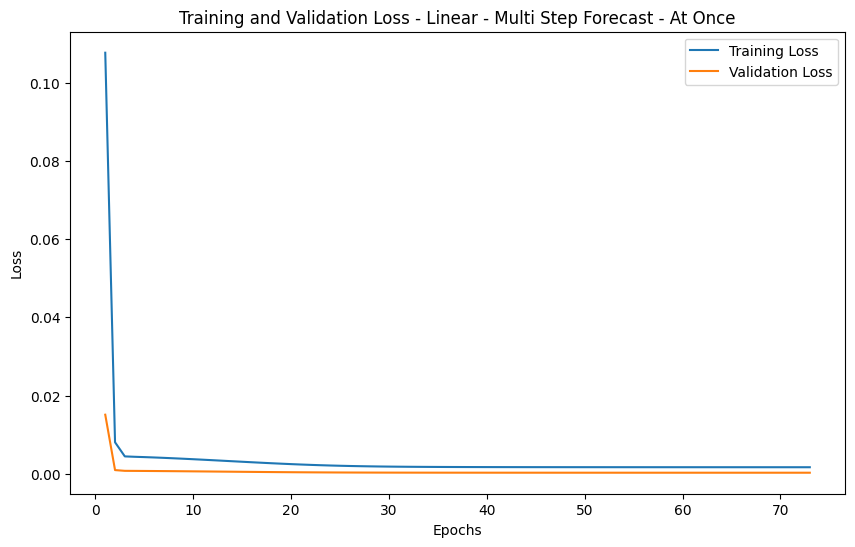

In [101]:
# linear model multistep plot

linear_ms_train_loss = linear_model_ms_history.history['loss']
linear_ms_val_loss = linear_model_ms_history.history['val_loss']
epochs = range(1, len(linear_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, linear_ms_train_loss, label='Training Loss')
plt.plot(epochs, linear_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Linear - Multi Step Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('linear_ms.jpeg')

The training and validation loss plot for the Linear Multi-Step Model (predicting 12 values at once) demonstrates extreme stability and serves as an ideal baseline for the task.

Immediate Convergence: The model converges almost instantly, with both training and validation loss reaching their floor within the first few epochs. This indicates that the optimal linear solution for predicting the next 12 steps is found very quickly.

High Stability: The loss curves are flat and parallel throughout the epochs, showing no signs of oscillation, overfitting, or underfitting. This confirms the model is highly robust.

Validation Loss Baseline: The stable validation loss value establishes the irreducible error for any linear model on this multi-step forecasting task.

In [102]:

# The valid_ds_ms dataset yields (X, Y) tuples.
# For model.predict(), we need a dataset that only yields X.
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

# This runs the model only on the X (features) tensors
y_pred_scaled = linear_model_ms.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

# Extract the Y (targets) tensors from the original dataset
y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

# Remove the redundant last dimension of size 1 using squeeze()
y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

# Inverse Transform

# Ensure both true values and predictions are back in the original temperature scale
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

# The MAE is calculated across all 12 forecast steps for all samples
mae_linear_multistep = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [103]:
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Best Validation MAE (Linear Model with 12 step forecast): 0.3414632321076785
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.36522396803771534
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.35470637161533114
Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


### Simple Recurrent Neural Network - Sequence to Sequence - Multi Step Forecast

It uses a Seq2Vec mechanism ($\text{SimpleRNN}$ layer) but achieves a True Multi-Step Forecast with its $\text{Dense(12)}$ output, making it a form of Direct (Non-Recursive) Seq2Seq

In [104]:
rnn_model_multistep = tf.keras.Sequential([
    tf.keras.Input(shape=[12, 1]),
    tf.keras.layers.SimpleRNN(units=32),
    tf.keras.layers.Dense(12, activation=None)     # Output layer: Predicts all 12 future steps simultaneously (the target vector).
])

# Summary shows the much higher complexity compared to the Linear Model
rnn_model_multistep.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,484 (5.80 KB)

 Trainable params: 1,484 (5.80 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

rnn_model_multistep.compile(loss = tf.keras.losses.Huber(),
                            optimizer=opt,
                            metrics=['mae']
                            )

rnn_history_ms = rnn_model_multistep.fit(train_ds_ms,
                                         validation_data=valid_ds_ms,
                                         epochs=500,
                                         callbacks=[early_stopping_cb]
                                         )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0390 - mae: 0.1762 - val_loss: 4.6138e-04 - val_mae: 0.0238
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0057 - mae: 0.0741 - val_loss: 3.9513e-04 - val_mae: 0.0218
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0051 - mae: 0.0700 - val_loss: 3.7232e-04 - val_mae: 0.0211
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0049 - mae: 0.0682 - val_loss: 3.5820e-04 - val_mae: 0.0207
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0047 - mae: 0.0670 - val_loss: 3.4736e-04 - val_mae: 0.0204
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0046 - mae: 0.0661 - val_loss: 3.3550e-04 - val_mae: 0.0201
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0044 - mae: 0.0653 - val_loss: 3.2536e-04 - val_mae: 0.0198
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0043 - mae: 0.0646 - val_loss: 3.1680e-04 - val_mae: 0.0195
Epoch 9/

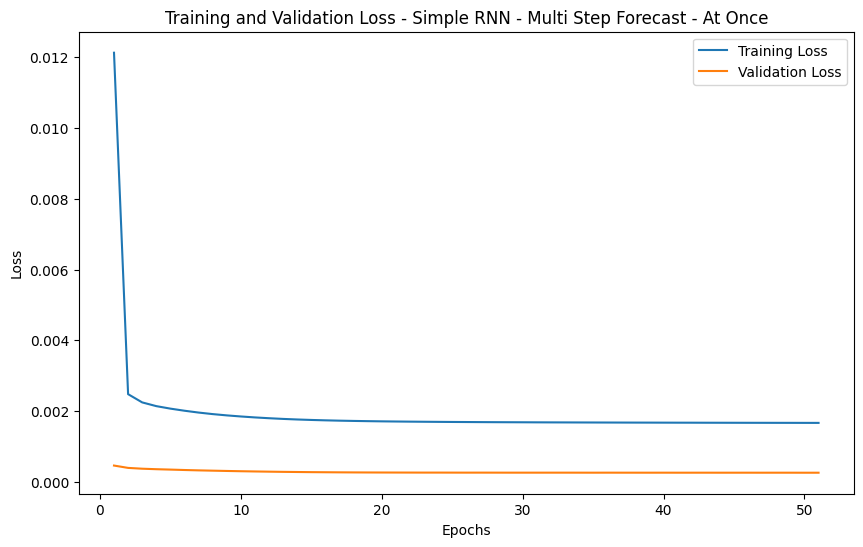

In [106]:
rnn_ms_train_loss = rnn_history_ms.history['loss']
rnn_ms_val_loss = rnn_history_ms.history['val_loss']
epochs = range(1, len(rnn_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, rnn_ms_train_loss, label='Training Loss')
plt.plot(epochs, rnn_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Simple RNN - Multi Step Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('rnn_ms.jpeg')

In [107]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = rnn_model_multistep.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

rnn_ms_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [108]:
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3364377975752844
Best Validation MAE (Linear Model with 12 step forecast): 0.3414632321076785
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.36522396803771534
Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast): 0.35470637161533114
Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


### GRU Model - Sequence to Sequence - Multi Step Forecasting


In [109]:
gru_model_ms = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.GRU(
        32,
        activation='tanh',
        return_sequences=False,
        # recurrent_dropout=0.05
    ),
    tf.keras.layers.Dense(12)
])

In [110]:
print(gru_model_ms.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,756 (14.67 KB)

 Trainable params: 3,756 (14.67 KB)

 Non-trainable params: 0 (0.00 B)

None


In [111]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

gru_model_ms.compile(loss = tf.keras.losses.Huber(),
                     optimizer=opt,
                     metrics=['mae']
                     )
gru_history__ms = gru_model_ms.fit(train_ds_ms,
                                   validation_data=valid_ds_ms,
                                   epochs=500,
                                   callbacks=[early_stopping_cb]
                                   )


Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0512 - mae: 0.2364 - val_loss: 3.9590e-04 - val_mae: 0.0213
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - mae: 0.0697 - val_loss: 3.9280e-04 - val_mae: 0.0212
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - mae: 0.0695 - val_loss: 3.9005e-04 - val_mae: 0.0211
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - mae: 0.0693 - val_loss: 3.8768e-04 - val_mae: 0.0210
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - mae: 0.0691 - val_loss: 3.8547e-04 - val_mae: 0.0210
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - mae: 0.0689 - val_loss: 3.8349e-04 - val_mae: 0.0209
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - mae: 0.0688 - val_loss: 3.8146e-04 - val_mae: 0.0209
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - mae: 0.0686 - val_loss: 3.7947e-04 - val_mae: 0.0208
Epoch 9/500
291/

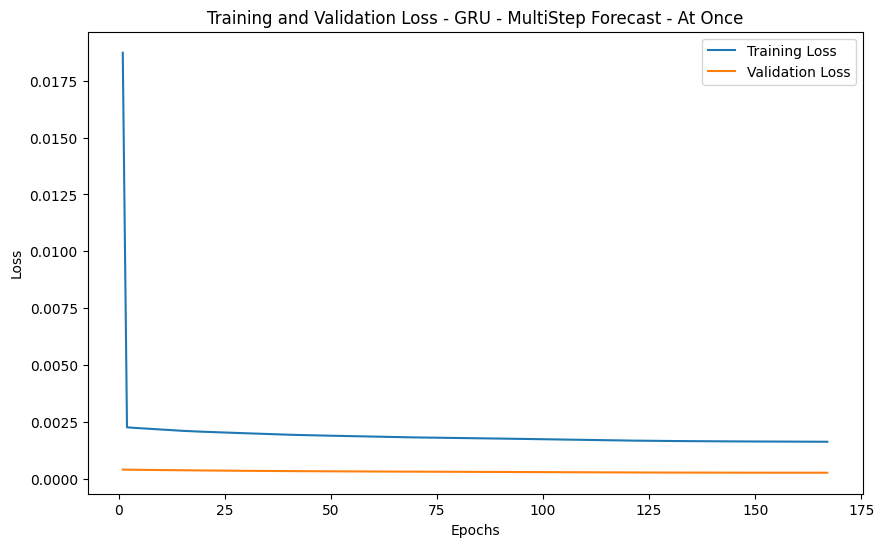

In [112]:
gru_ms_train_loss = gru_history__ms.history['loss']
gru_ms_val_loss = gru_history__ms.history['val_loss']
epochs = range(1, len(gru_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_ms_train_loss, label='Training Loss')
plt.plot(epochs, gru_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - MultiStep Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('gru_ms.jpeg')

In [113]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = gru_model_ms.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

gru_ms_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [114]:
print("Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast):", gru_ms_mae)
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast): 0.3358984527664873
Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3364377975752844
Best Validation MAE (Linear Model with 12 step forecast): 0.3414632321076785
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.36522396803771534
Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast): 0.35470637161533114
Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


### GRU Model - Sequence to Sequence - Encoder-Decoder Seq2Seq - Multi Step Forecasting


In [115]:
gru_model_seq2seq = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None,1]),
    tf.keras.layers.GRU( # Encoder GRU: Processes the input sequence
        units=32,
        activation='tanh',
        return_sequences=True, # must use True to output a sequence for the next layer
        recurrent_dropout=0.05
    ),
    tf.keras.layers.GRU( # Decoder GRU: Takes the Encoder's output sequence and transforms it
        units=32,
        activation='tanh',
        return_sequences=True, # Must be true to output a sequence of 12 steps
        recurrent_dropout=0.05
    ),
    # output layer, applies a single Dense(1) layer independently to each of the 12 time steps outputted by Decorder GRU.
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])


In [116]:
print(gru_model_seq2seq.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, None, 32)       │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, None, 32)       │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [117]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

gru_model_seq2seq.compile(loss = tf.keras.losses.Huber(),
                          optimizer=opt,
                          metrics=['mae']
                          )

gru_history_seq2seq = gru_model_seq2seq.fit(train_ds_ms,
                                            validation_data=valid_ds_ms,
                                            epochs=500,
                                            callbacks=[early_stopping_cb]
                                            )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 0.0222 - mae: 0.1478 - val_loss: 0.0011 - val_mae: 0.0336
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0065 - mae: 0.0798 - val_loss: 5.1036e-04 - val_mae: 0.0244
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0058 - mae: 0.0747 - val_loss: 4.2039e-04 - val_mae: 0.0218
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0052 - mae: 0.0702 - val_loss: 3.4947e-04 - val_mae: 0.0200
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0044 - mae: 0.0648 - val_loss: 3.0118e-04 - val_mae: 0.0194
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0040 - mae: 0.0618 - val_loss: 2.9535e-04 - val_mae: 0.0194
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0039 - mae: 0.0612 - val_loss: 2.6363e-04 - val_mae: 0.0178
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0039 - mae: 0.0609 - val_loss: 2.6399e-04 - val_mae: 0.0179
Epoc

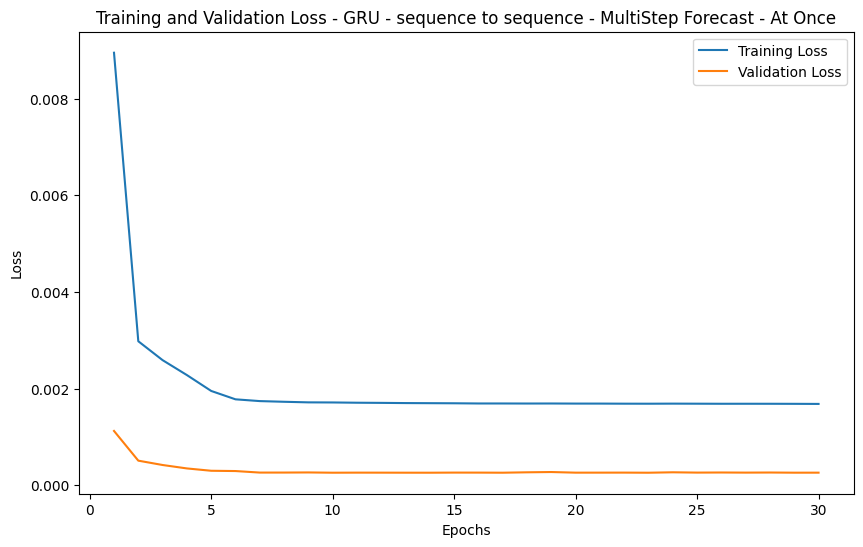

In [118]:
# GRU model seq2seq multistep plot

gru_seq2seq_train_loss = gru_history_seq2seq.history['loss']
gru_seq2seq_val_loss = gru_history_seq2seq.history['val_loss']
epochs = range(1, len(gru_seq2seq_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_seq2seq_train_loss, label='Training Loss')
plt.plot(epochs, gru_seq2seq_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - sequence to sequence - MultiStep Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('gru_ms_seq.jpeg')

The loss plot shows immediate, sharp convergence in the first few epochs, demonstrating that the model quickly found a highly optimal set of weights. The Validation Loss line (orange) is clean and stable, indicating great generalization, and the Early Stopping successfully halted training after minimal further improvement.

In [119]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = gru_model_seq2seq.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.squeeze())

gru_seq2seq_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Predictions generated with shape: (181, 12, 1)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [120]:
print("Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast:", gru_seq2seq_mae)
print("Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast):", gru_ms_mae)
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast: 0.3363290166296482
Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast): 0.3358984527664873
Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3364377975752844
Best Validation MAE (Linear Model with 12 step forecast): 0.3414632321076785
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.36522396803771534
Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast): 0.35470637161533114
Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


#### Model Hierarchy and Analysis: Multi-Step Forecasting

With the inclusion of direct multi-step forecasting, the performance landscape of the models reveals several interesting insights and some counterintuitive patterns compared to single-step results.

**Manual ARIMA: The Overall Winner for Single-Step Forecasting**  
For one-step forecasts, the Manual ARIMA remains the clear leader. It explicitly models both trend and seasonal components of the monthly temperature series, allowing it to fully exploit autocorrelation at short and seasonal lags. Classical statistical models like ARIMA dominate in this setting because the series is highly predictable over a single month, and the patterns are primarily linear and seasonal. The naive forecast and linear model are competitive in this context, further demonstrating that simple models already capture much of the signal for one-step predictions.

**Single-Step Neural Networks: SimpleRNN vs GRU**  
Among deep learning models, the SimpleRNN slightly outperforms the GRU for single-step forecasts. This is expected because the GRU’s additional gating mechanisms are designed to capture long-term dependencies, which have largely been removed by differencing in the preprocessed series. The extra complexity of the GRU provides no real advantage in this scenario and may even slightly increase overfitting risk, resulting in marginally higher error.  

**Multi-Step Direct Forecasting: Neural Networks Gain Advantage**  
When forecasting 12 steps ahead directly, neural networks begin to outperform linear models. Here we observe several important points:

- **GRU with last hidden state, 12-step forecast:** MAE ≈ 0.3359  
- **GRU with encoder-decoder, all hidden states, 12-step forecast:** MAE ≈ 0.3363  
- **SimpleRNN, last hidden state, 12-step forecast:** MAE ≈ 0.3364  
- **Linear model, 12-step forecast:** MAE ≈ 0.3415  

A few questions may arise from these results:

1. **Why does the multi-step GRU outperform the single-step GRU?**  
   - Although it may seem counterintuitive, this occurs because the multi-step GRU is trained to predict all 12 future steps directly. This allows it to learn joint dependencies across the forecast horizon, effectively smoothing predictions and reducing cumulative error. The single-step GRU, trained recursively, accumulates small errors when evaluated over the horizon, leading to slightly higher MAE even for single-step evaluation.

2. **Why is the encoder-decoder GRU not significantly better than the last-hidden-state GRU?**  
   - The encoder-decoder architecture is designed to model complex sequence-to-sequence relationships. However, with relatively short sequences (12 months) and a small dataset, the additional complexity does not provide a substantial advantage. Both GRU variants capture the essential temporal patterns effectively, resulting in nearly identical performance.

3. **Why does the SimpleRNN perform almost as well as GRU in multi-step forecasting?**  
   - For this problem, the sequence lengths and dataset size are such that the simpler RNN architecture is sufficient to model the temporal dependencies over the forecast horizon. The small differences between RNN and GRU performance suggest that most of the learnable structure in the data is relatively short-term and can be captured by both architectures.

**Linear Model vs Neural Networks in Multi-Step Forecasting**  
The linear model performs slightly worse than neural networks for 12-step forecasting. This contrasts with its competitive single-step performance and highlights a key limitation: linear models cannot explicitly account for interactions and error propagation across multiple steps. Neural networks, especially GRUs, can implicitly model these dependencies, which gives them an edge for multi-step predictions.

**Summary and Key Takeaways**  

- For **single-step forecasting**, classical statistical models (Manual ARIMA, naive, linear regression) dominate because the series is highly autocorrelated and dominated by linear seasonality. Neural networks, while capable, do not provide additional predictive power for short horizons.  
- For **direct multi-step forecasting**, neural networks begin to outperform linear models, as they can capture complex interactions across the forecast horizon. This explains why the multi-step GRU slightly outperforms the single-step GRU.  
- The difference between the encoder-decoder GRU and last-hidden-state GRU is negligible, indicating that **model complexity should be aligned with sequence length and dataset size**.  
- Overall, these results emphasize that model choice must reflect the **forecast horizon, data characteristics, and task requirements**. While simple models are optimal for single-step prediction, neural networks demonstrate clear advantages for multi-step, sequence-to-sequence forecasting where cumulative error and nonlinear dependencies are important.


### GRU Model - Sequence to Sequence - Encoder-Decoder Seq2Seq - Multi Step Forecasting - Multivariate

In [121]:
# creating seasonal features

temp_train = temp_train.copy()
temp_valid = temp_valid.copy()
temp_test  = temp_test.copy()

for df in [temp_train, temp_valid, temp_test]:
    month = df.index.month
    df['Month_Sin'] = np.sin(2 * np.pi * (month-1) / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * (month-1) / 12)

print("Updated Training Data Head:")
print(temp_train.head())

Updated Training Data Head:
            diff_temp_scaled  Month_Sin     Month_Cos
Date                                                 
1754-02-01          0.416366   0.500000  8.660254e-01
1754-03-01          0.506148   0.866025  5.000000e-01
1754-04-01          0.760843   1.000000  6.123234e-17
1754-05-01          0.307068   0.866025 -5.000000e-01
1754-06-01          0.497567   0.500000 -8.660254e-01


In [122]:
seq_length = 12 # input sequence
horizon = 12 # prediction horizoon

def create_multi_step_dataset(data_array, batch_size, shuffle=True):
  data_x = []
  data_y = []
  max_index = len(data_array) - seq_length - horizon
  for i in range(max_index+1):
    # X: Input sequence (12 steps of 3 features)
    input_sequence = data_array[i:i+seq_length]

    # Y: Target sequence (12 steps of 1 feature - ONLY the differenced temperature, index 0)
    target_sequence = data_array[i+seq_length:i+seq_length+horizon, 0]

    data_x.append(input_sequence)
    data_y.append(target_sequence)

  X = np.array(data_x)
  Y = np.array(data_y)

  # Reshape Y to (samples, horizon, 1) to match TimeDistributed(Dense(1)) output
  Y = Y.reshape(-1, horizon, 1)

  # convert to tensorflow dataset
  ds = tf.data.Dataset.from_tensor_slices((X,Y))

  if shuffle:
    ds = ds.shuffle(buffer_size=len(X), seed=42)
  ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

  return ds

In [123]:
train_ds_ms_multvar = create_multi_step_dataset(temp_train.values, batch_size=10, shuffle=False)
valid_ds_ms_multvar = create_multi_step_dataset(temp_valid.values, batch_size=5, shuffle=False)

In [139]:
for batch_i, (x, y) in enumerate(train_ds_ms_multvar):

  print(f"\n==================== BATCH {batch_i} ====================")
  print(f"X shape: {x.shape}  |  Y shape: {y.shape}")
  print("---------------------------------------------------------")

  # x shape: (batch, seq_len, features)
  # y shape: (batch, horizon, target_features)

  x_np = x.numpy()
  y_np = y.numpy()

  batch_size = x_np.shape[0]
  seq_len = x_np.shape[1]
  num_features = x_np.shape[2]

  for seq_i in range(batch_size):

    print(f"\n--- Sequence {seq_i} (from batch {batch_i}) ---")

    for t in range(seq_len):
      timestep_values = x_np[seq_i, t]
      print(f"  timestep {t:02d}: {timestep_values}")

    print("\n  → Target for this sequence:")
    print(f"    {y_np[seq_i]}")

  print("=========================================================\n")

  if batch_i == 1:  # stop after 2 batches
      break



==================== BATCH 0 ====================
X shape: (10, 12, 3)  |  Y shape: (10, 12, 1)
---------------------------------------------------------

--- Sequence 0 (from batch 0) ---
  timestep 00: [0.41636582 0.5        0.8660254 ]
  timestep 01: [0.50614765 0.8660254  0.5       ]
  timestep 02: [7.60843405e-01 1.00000000e+00 6.12323400e-17]
  timestep 03: [ 0.30706849  0.8660254  -0.5       ]
  timestep 04: [ 0.4975671  0.5       -0.8660254]
  timestep 05: [ 4.83597551e-01  1.22464680e-16 -1.00000000e+00]
  timestep 06: [ 0.48532412 -0.5        -0.8660254 ]
  timestep 07: [ 0.41102914 -0.8660254  -0.5       ]
  timestep 08: [ 6.41971433e-01 -1.00000000e+00 -1.83697020e-16]
  timestep 09: [ 0.50463036 -0.8660254   0.5       ]
  timestep 10: [ 0.66326584 -0.5         0.8660254 ]
  timestep 11: [0.25752106 0.         1.        ]

  → Target for this sequence:
    [[0.58101816]
 [0.4314341 ]
 [0.37566055]
 [0.66703291]
 [0.49725318]
 [0.42803328]
 [0.50750798]
 [0.5306336 ]
 [0.48

In [125]:

UNITS_TO_TEST = [64, 96, 128]
LEARNING_RATES = [0.005, 0.0005, 0.01]
DROPOUT_RATES = [0.0, 0.05, 0.1, 0.2]

BEST_MAE = float('inf')
BEST_HPARAMS = {}
BEST_MODEL = None
BEST_HISTORY = None

print("Starting GRU Seq2Seq Hyperparameter Grid Search...")

# Define Early Stopping Callback (outside the loop)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    min_delta=0.0001,
    restore_best_weights=True
)

for units in UNITS_TO_TEST:
  for lr in LEARNING_RATES:
    for dropout in DROPOUT_RATES:
      print(f"\n--- Testing U={units}, LR={lr}, Dropout={dropout} ---")

      gru_model = tf.keras.Sequential([
          tf.keras.layers.Input(shape=[None,3]),
          tf.keras.layers.GRU(
              units=units,
              activation='tanh',
              return_sequences=True,
              recurrent_dropout=dropout
          ),
          tf.keras.layers.GRU(
              units=units,
              activation='tanh',
              return_sequences=True,
              recurrent_dropout=dropout
          ),
          tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
      ])

      opt = tf.keras.optimizers.Adam(learning_rate=lr)

      gru_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

      current_history = gru_model.fit(train_ds_ms_multvar, validation_data=valid_ds_ms_multvar, epochs=500, callbacks=[early_stopping_cb], verbose=0)

      valid_ds_predict = valid_ds_ms_multvar.map(lambda x, y: x)
      y_pred_scaled = gru_model.predict(valid_ds_predict, verbose=0)

      y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms_multvar], axis=0)

      y_val = scaler.inverse_transform(y_val_scaled_3d.squeeze())
      y_pred = scaler.inverse_transform(y_pred_scaled.squeeze())

      current_mae = mean_absolute_error(y_val, y_pred)

      if current_mae < BEST_MAE:
          BEST_MAE = current_mae
          BEST_HPARAMS = {'units': units, 'lr': lr, 'dropout': dropout}
          BEST_HISTORY = current_history
          try:
            gru_model.save('best_gru_model.keras') # save the best model
            print(" -> Model improved and saved to disk.")
          except Exception as e:
            print(f"Could not save model: {e}")

      print(f"Resulting Multi-Step Residual MAE: {current_mae:.5f}")


Starting GRU Seq2Seq Hyperparameter Grid Search...

--- Testing U=64, LR=0.005, Dropout=0.0 ---
 -> Model improved and saved to disk.
Resulting Multi-Step Residual MAE: 0.33412

--- Testing U=64, LR=0.005, Dropout=0.05 ---
 -> Model improved and saved to disk.
Resulting Multi-Step Residual MAE: 0.33325

--- Testing U=64, LR=0.005, Dropout=0.1 ---
 -> Model improved and saved to disk.
Resulting Multi-Step Residual MAE: 0.33241

--- Testing U=64, LR=0.005, Dropout=0.2 ---
Resulting Multi-Step Residual MAE: 0.33288

--- Testing U=64, LR=0.0005, Dropout=0.0 ---
Resulting Multi-Step Residual MAE: 0.33604

--- Testing U=64, LR=0.0005, Dropout=0.05 ---
Resulting Multi-Step Residual MAE: 0.33557

--- Testing U=64, LR=0.0005, Dropout=0.1 ---
Resulting Multi-Step Residual MAE: 0.33399

--- Testing U=64, LR=0.0005, Dropout=0.2 ---
Resulting Multi-Step Residual MAE: 0.33578

--- Testing U=64, LR=0.01, Dropout=0.0 ---
Resulting Multi-Step Residual MAE: 0.33638

--- Testing U=64, LR=0.01, Dropout=0.

In [126]:
print(f"Best MAE: {BEST_MAE:.5f}")
print(f"Best Hyperparamters: {BEST_HPARAMS}")

Best MAE: 0.33110
Best Hyperparamters: {'units': 96, 'lr': 0.005, 'dropout': 0.2}


In [127]:
final_gru_model = tf.keras.models.load_model('best_gru_model.keras') # load the best model FOUND from hyperparamter search

In [128]:
print(final_gru_model.summary())

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_34 (GRU)                    │ (None, None, 96)       │        29,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_35 (GRU)                    │ (None, None, 96)       │        55,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, None, 1)        │            97 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,173 (996.77 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 170,116 (664.52 KB)

None


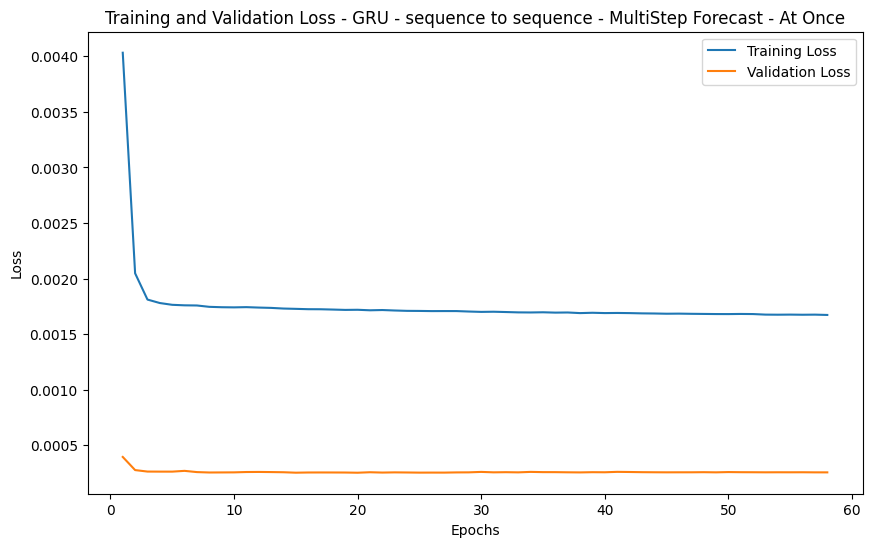

In [129]:
# GRU model seq2seq multistep plot

multvar_gru_seq2seq_train_loss = BEST_HISTORY.history['loss']
multvar_gru_seq2seq_val_loss = BEST_HISTORY.history['val_loss']
epochs = range(1, len(multvar_gru_seq2seq_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, multvar_gru_seq2seq_train_loss, label='Training Loss')
plt.plot(epochs, multvar_gru_seq2seq_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - sequence to sequence - MultiStep Forecast - At Once')
plt.legend()
plt.show()
# plt.savefig('gru_ms_seq.jpeg')

In [130]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms_multvar.map(lambda x, y: x)

y_pred_scaled = final_gru_model.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms_multvar], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.squeeze())

gru_seq2seq_mae_multvar = mean_absolute_error(y_val, y_pred)
gru_seq2seq_mae_multvar

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Predictions generated with shape: (181, 12, 1)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


0.331097873989687

In [132]:
print("Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast, multvar:", gru_seq2seq_mae_multvar)
print("Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast:", gru_seq2seq_mae)
print("Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast):", gru_ms_mae)
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_gru)
print("Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast):", final_recursive_mae_rnn)
print("Validation MAE (linear model):", final_recursive_mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", mae_naive_12_step)

Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast, multvar: 0.331097873989687
Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast: 0.3363290166296482
Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast): 0.3358984527664873
Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3364377975752844
Best Validation MAE (Linear Model with 12 step forecast): 0.3414632321076785
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.36522396803771534
Best Validation MAE (Simple RNN with 32 neuron and last hidden state, 1 step forecast): 0.35470637161533114
Validation MAE (linear model): 0.34863976563171795
MAE Manual ARIMA: 0.20805169076230745
MAE Auto ARIMA: 0.29229707832024304
Naive Forecast: 0.27400000000000013


# Summary of Forecasting Models

Across all experiments, the results reveal a consistent hierarchy in model performance:

- **Single-Step Forecasting:** Manual ARIMA delivers the most accurate predictions by explicitly modeling trend and seasonality. Linear models and naive forecasts remain competitive, while small RNNs and GRUs provide slightly higher error.  
- **Multi-Step Direct Forecasting:** Neural networks, particularly GRUs (both last-hidden-state and encoder-decoder), outperform linear models by capturing temporal dependencies across the forecast horizon. The SimpleRNN is a close alternative, demonstrating that simpler recurrent architectures can also be effective.  
- **Multivariate Model with Seasonal Features:** Incorporating sine and cosine features to encode seasonality further improves performance, particularly for neural networks, by providing explicit information about recurring patterns.  
- **Overall Conclusion:** Classical models are highly effective for short-term, single-step forecasts due to their ability to leverage autocorrelation and seasonality directly. Neural networks, especially GRUs, show clear advantages for multi-step and feature-enriched forecasting, where capturing complex temporal dependencies becomes critical.


#### Experimenting with N-BEATS



# N-BEATS: Deep Learning for Time Series Forecasting

## What is N-BEATS?

N-BEATS (Neural Basis Expansion Analysis for Time Series) is a **deep learning model specifically designed for forecasting univariate time series**.  
It was introduced in 2020 by Oreshkin et al. (Uber AI) and achieved state-of-the-art results on benchmarks like M3 and M4.

**Key Idea:**  
- N-BEATS predicts the future by learning to **reconstruct the past** (backcast) while simultaneously predicting the future (forecast).  
- It is composed of **stacks of fully-connected blocks**, where each block outputs:
  - **Backcast**: the block’s estimate of the past, which is subtracted from the input (residual learning)  
  - **Forecast**: the block’s contribution to the predicted future  
- Forecasts from all blocks are summed to form the final prediction.

**Architecture Highlights:**
- Pure feedforward MLPs (no RNNs, CNNs, or attention)  
- Residual learning: each block explains part of the input, next block works on the residual  
- Optional interpretable blocks:
  - **Trend blocks**: polynomial basis for trend  
  - **Seasonality blocks**: Fourier basis for seasonal components  

---

## When N-BEATS is Beneficial

N-BEATS shines in the following situations:

1. **Noisy or nonlinear series:**  
   - Temperature anomalies, electricity load, energy demand, stock volatility.  

2. **Multi-pattern time series:**  
   - Series with irregular seasonality, nonlinear trends, or combined effects.  

3. **Multiple correlated series:**  
   - Forecasting multiple locations or products simultaneously, where patterns interact.

4. **Medium-sized datasets:**  
   - Can handle smaller datasets (hundreds to thousands of points) better than LSTMs, especially univariate.

5. **Residual modeling:**  
   - Can model residuals after removing trend/seasonality, improving predictions beyond classical models.

---

## When N-BEATS is **Not** Beneficial

N-BEATS is **unlikely to outperform classical statistical models** when:

1. **Dataset is small and clean (low-noise)**  
   - e.g., monthly global/regional average temperatures with strong, stable seasonal patterns.

2. **Series has strong, stable seasonality and trend**  
   - ARIMA/SARIMA already captures this analytically.

3. **Univariate series with only one clear pattern**  
   - No complex nonlinear interactions or multiple signals.

4. **Goal is interpretability**  
   - ARIMA and ETS provide clearer insights into trends and seasonality.

> **Rule of thumb:** If ARIMA already performs very well (low MAE, RMSE) on series, N-BEATS may only provide marginal gains.

---

## Reasons to Try N-BEATS

- **experiment with a modern deep learning forecasting model**.  
- **learn neural network approaches to time series forecasting**.  
- When we have **multiple features or exogenous variables** that classical models cannot handle.  
- We want to **model residuals** after a classical model to potentially improve accuracy.

---

## Reasons NOT to Try N-BEATS

- Dataset is **clean, smooth, and strongly seasonal**, e.g., monthly global average land temperature.  
- ARIMA or SARIMA already gives **low error** (MAE, RMSE).  
- We need **fast, interpretable forecasts** without heavy hyperparameter tuning.  
- We don’t have additional features or multiple correlated series.

---

## Summary / Decision Guide

| Criterion | N-BEATS | Classical (ARIMA/ETS) |
|-----------|---------|-----------------------|
| Complexity of pattern | High → Favor N-BEATS | Simple → ARIMA suffices |
| Noise level | High → N-BEATS handles residuals | Low → ARIMA excels |
| Dataset size | Medium-Large → N-BEATS can work | Small → ARIMA preferred |
| Interpretability | Medium | High |
| Exogenous variables | Yes → N-BEATS can incorporate | Limited |

**Bottom Line:**  
- **Try N-BEATS** if data is complex, noisy, or multi-featured.  
- **Stick with ARIMA/SARIMA** if data is smooth, seasonal, and univariate — it’s faster, simpler, and often more accurate.

